## $\textbf{Inferring Musical Time Signature via Apple Watch Logs of Conductor Wrist Motion}$

$\textbf{Author:}\text{ Ryan Burns}$

$\text{When conducting a chamber group or orchestra, a musical conductor uses a designated baton pattern for each possible time signature a musical}$
$\text{score could be written in. Suppose someone were to wear an Apple Watch on their right wrist while conducting, (assume watch IMU data is}$
$\text{logged at 100 Hz). It is not unreasonable to suspect that we could train a machine learning model to predict the time signature corresponding }$
$\text{to particular wrist motion patterns. A small amount of data is studied to prove this concept using }\textit{long short-term memory (LSTM)}\text{ networks.}$
$\text{For a great overview of LSTM and other recurrent units, see: }\textit{https://colah.github.io/posts/2015-08-Understanding-LSTMs/}\text{. While intended }$
$\text{for sequential data (e.g., the quasi-cyclostationary wrist motions of a conductor), we also admit that this is a small amount of training and }$
$\text{validation data, so the generalization performance of these models across a variety of conductors, time signatures, and tempos could prove}$
$\text{quite poor. With generalization performance being a concern, we a couple techniques to hopefully mitigate some amount of overfitting. }$

$\text{We add Gaussian noise to the input signals to randomly vary input to the network, in addition to applying random dropout to a subset of}$
$\text{the connections within the network at a fixed probability. The model is trained on a subset of data and validated on the remaining data.}$

$\text{This specific deep learning architecture is comprised of a single convolutional layer fed to a dense hyperbolic tangent layer for feature,}$
$\text{extraction preceding the long short-term memory layer. The LSTM units make use of both types of dropout available (ordinary and recurrent)}$
$\text{as measures to reduce overfitting. A multidimensional sliding window is applied to the accelerometer, gyroscope, and IMU-fused watch}$
$\text{orientation quaternion at the input layer of the network.}$

$\textbf{Motion Class Labels:}$

$\text{All class labels are defined for a right-handed user. An orchestral conductor varies their baton pattern according to 1 of 4 possible states, }$
$\text{comprised of 3 time signature classes and a resting class (i.e., cessation of baton motion).}$

$\text{0 }\leftrightarrow [1\enspace0\enspace0\enspace0]\leftrightarrow \text{REST}\Longrightarrow\text{conductor has ceased baton motion (no conducting)}$

$\text{1 }\leftrightarrow [0\enspace1\enspace0\enspace0]\leftrightarrow {2/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{2}{4}}\text{ time signature}$

$\text{2 }\leftrightarrow [0\enspace0\enspace1\enspace0]\leftrightarrow {3/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{3}{4}}\text{ time signature}$

$\text{3 }\leftrightarrow [0\enspace0\enspace0\enspace1]\leftrightarrow {4/4}\Longrightarrow\text{conductor proceeds with baton motion consistent with a }\mathbf{\genfrac{}{}{0pt}{}{4}{4}}\text{ time signature}$

$\text{For more information on musical time signatures, visit: }\textit{https://en.wikipedia.org/wiki/Time_signature}.$

![title](baton_motion.png)

$\text{The baton patterns for each time signature of interest are depicted diagramatically above. We assume a tech enthusiast conductor who desires}$
$\text{an Apple Watch app/experience for automatic discrimination between the 3 time signatures above, in addition to a catch-all }\textit{at-rest}\text{ state. We }$
$\text{also assume that this conductor would like automatic time-signature inference to be as tempo-agnostic as possible. Be it }\textit{largo}\text{ or }\textit{prestissimo}\text{,}$
$\text{we assume that the tempo of the musical composition of question would not fool the ideal baton pattern classifier. As such, while the amount}$
$\text{of data collected for this analysis is still limited in its size and diversity (i.e., we can assume overfit models), efforts have been made during}$
$\text{data collection to vary the tempo across each time signature's constituent wrist motion observations. The duration (in seconds or measures)}$
$\text{of each time signature's wrist motion subsequence is also varied during collection. We create an aggregated dataset of independent concatenated}$
$\text{collects for supervised learning in the code below.}$

$\textbf{Note On Labeling:}$

$\text{SensorLog labels are recorded in real time using the app's class label buttons for a streaming iPhone. This iPhone logs data concurrently with}$
$\text{an Apple Watch, which also reports its own class labels. Since toggling of the Apple Watch's class labels using the SensorLog UI on the watch }$
$\text{face would interfere with data collection of wrist motion, we use the }\textit{iPhone}\text{ to log wrist motion labels. By time-aligning the iPhone and Apple}$
$\text{Watch streams below (i.e., using POSIX timestamps), we can readily provide wrist motion labels for the Apple Watch motion signals without}$
$\text{interfering with their trajectory as just described. In short, real-time motion labeling is available through dual stream of Apple Watch }$
$\text{iPhone data, where the former provides the motion observations of interest and the latter provides a mechanism for real-time motion labeling.}$

### $\textbf{Import Packages}$

In [1]:
import pandas as pd
from os import getcwd, environ;
from itertools import product as iter_prod;
from matplotlib import pyplot as plt;
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import array, hstack, argmax, ones, zeros, log10;
from numpy import logical_or, logical_not, expand_dims, flip;
from numpy import  abs, arange, shape, newaxis, sum, flipud;
from numpy import nan_to_num;
from scipy.signal import parzen;

from tensorflow.keras.models import Sequential, Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import CategoricalAccuracy;
from tensorflow.keras.metrics import Precision, Recall, AUC;
from tensorflow.keras.layers import Dropout, LSTM, Dense;
from tensorflow.keras.layers import Activation, Reshape, Conv1D;
from tensorflow.keras.layers import Input, GaussianNoise;
from sklearn.metrics import confusion_matrix;

from SensorLogUtils import convert_iPhone_units;

environ['KMP_DUPLICATE_LIB_OK']='True'

### $\textbf{Class Label Definitions}$

In [2]:
# Ordinal motion class labels
class_table = pd.DataFrame({
    'REST': {
        'id': 'REST', 
        'description': 'no conducting / baton pattern',
        '1-hot label': [1,0,0,0],
        'ordinal label': 0
    },
    '2/4': {
        'id': '2/4', 
        'description': 'conducting pattern for a 2/4 time signature',
        '1-hot label': [0,1,0,0],
        'ordinal label': 1
    },
    '3/4': {
        'id': '3/4', 
        'description':'conducting pattern for a 3/4 time signature',
        '1-hot label': [0,0,1,0],
        'ordinal label': 2
    },
    '4/4': {
        'id': '4/4', 
        'description':'conducting pattern for a 4/4 time signature',
        '1-hot label': [0,0,0,1],
        'ordinal label': 3
    }
});

# Number of classes
C = 4;

# Print class table
class_table

,REST,2/4,3/4,4/4
id,REST,2/4,3/4,4/4
description,no conducting / baton pattern,conducting pattern for a 2/4 time signature,conducting pattern for a 3/4 time signature,conducting pattern for a 4/4 time signature
1-hot label,"[1, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]"
ordinal label,0,1,2,3


### $\textbf{Specify & Load Dataset}$

In [3]:
################
# Specify data #
################

# Specify local data storage path
data_path = getcwd() + '/data';

# Collect file string ID
collect_IDs = [
    'time_signatures_collect1',
    'time_signatures_collect2'
];

# Build string filename corresponding to collect_ID
collect_files = [
    (data_path + '/labeled_' + collect_ID + '_appleWatch.csv')
for collect_ID in collect_IDs];

#############
# Load data #
#############

# Load and concatenate dataframes for all
# labeled collects in list collect_IDs
df = pd.concat([pd.read_csv(f, 
    error_bad_lines=False,
    warn_bad_lines=False)
    for f in collect_files
],axis=0,ignore_index=True);

# Data fields (column headers)
fields = [fd for fd in df];

# Length of dataframe
N = len(df); # (samples)

### $\textbf{Select IMU Data & 1-Hot Class Labels}$

In [4]:
# Select input signals
x = nan_to_num(array(df[[
    'accelerometerAccelerationX(m/s^2)',
    'accelerometerAccelerationY(m/s^2)',
    'accelerometerAccelerationZ(m/s^2)',
    'motionRotationRateX(rad/s)',
    'motionRotationRateY(rad/s)',
    'motionRotationRateZ(rad/s)',
    'motionQuaternionW(R)',
    'motionQuaternionX(R)',
    'motionQuaternionY(R)',
    'motionQuaternionZ(R)'
]]));

# Define 1-hot labels
y = nan_to_num(array(df[[
    
    # List all class headers in table above
    class_name for class_name in class_table
]]));

### $\textbf{Specify Sliding Observation Window Parameters}$

In [5]:
# Number of raw sensor samples (N)
# and their dimensionality (D)
N, D = shape(x);

# Sliding obs. window length
M = 128; # (samples)

# Step size of obs. window
m = 10;  # (samples)

# Linear grid for sliding observation
# window reflecting window length & step
# size specified above, mapped to raw
# sensor samples n = M, M + m, M + 2m, ...
obs_idx = [n for n in range(M,N,m)];

# Define Parzen window to weight observations
w = expand_dims(parzen(M),axis=1);

### $\textbf{Define Observations & Class Labels}$

In [6]:
# Windowed observation sequence input to model
X = array([w * x[(n - M):n,:] for n in obs_idx]);

# Ground truth 1-hot window-resolution class labels
Y = array([
    [1 if c == argmax(sum(w * y[(n - M):n,:],0)) 
    else 0 for c in range(C)] for n in obs_idx]);

### $\textbf{Training Parameters}$

In [7]:
# Fraction of dataset to hold 
# out for model validation
pct_validation = 0.25;

# Total number of obs.
N_obs = len(X);

# Number of training epochs
N_epoch = 5000;

# Number of batches
N_batch = int(N_obs / 1);

### $\textbf{Define Machine Learning Model}$

In [8]:
#####################################################
# Define model architecture w/ Keras functional API #
#####################################################

# Input layer - M x D observation window
input_layer = Input((M,D));

# Add Gaussian noise to M x D input
h0 = GaussianNoise(5e-3)(input_layer);

# Convolutional layer, rectified linear unit activation
h1 = Conv1D(M,M,activation='relu')(h0);

# Dense hyperbolic tangent activation layer
h2 = Dense(M,activation='tanh')(h1);

# Long short-term memory layer
h3 = LSTM(2 * M,activation='tanh',
    dropout=0.5,
    recurrent_dropout=0.5)(h2);

# Output layer - C x 1 softmax class activation 
output_layer = Dense(C,activation='softmax')(h3);

# Set up Keras Model() instance
model = Model(
    inputs=input_layer,  # Model inputs
    outputs=output_layer # Model outputs
);

###########################
# Define loss & optimizer #
###########################

# Set RMSprop optimization for 
# speed-of-convergence purposes
opt = RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.001,
    epsilon=1e-07,
    name="RMSprop"
);

# Model compilation, using categorical
# cross-entropy error w/ RMSprop
model.compile(
    
    # Error/loss function
    loss='categorical_crossentropy', 
    
    # Use RMSprop
    optimizer=opt,
    
    # List metrics here
    metrics=[
        CategoricalAccuracy(),
        AUC(),
        Precision(),
        Recall()
    ]
);

# Print a summary table
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 10)]         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 128, 10)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            163968    
_________________________________________________________________
dense (Dense)                (None, 1, 128)            16512     
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 575,748
Trainable params: 575,748
Non-trainable params: 0
_______________________________________________________

### $\textbf{Train Machine Learning Model}$

In [9]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # windowed observations
    y=Y, # 1-hot motion class labels
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=pct_validation,
    
    # False for time series
    shuffle=False,
    
    # Other misc params
    sample_weight=None,
    validation_freq=1,
    max_queue_size=10,
    
    # Parallelize job across 2 workers
    workers=2,
    use_multiprocessing=True
);

Train on 6156 samples, validate on 2052 samples
Epoch 1/5000
6156/6156 [==============================] - 5s 835us/sample - loss: 1.3873 - categorical_accuracy: 0.2437 - auc: 0.5079 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.2486 - val_categorical_accuracy: 0.3952 - val_auc: 0.7334 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5000
6156/6156 [==============================] - 1s 160us/sample - loss: 1.3041 - categorical_accuracy: 0.3455 - auc: 0.6630 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1998 - val_categorical_accuracy: 0.4727 - val_auc: 0.7675 - val_precision: 0.9773 - val_recall: 0.0210
Epoch 3/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 1.2203 - categorical_accuracy: 0.4683 - auc: 0.7421 - precision: 0.8750 - recall: 0.0182 - val_loss: 1.0531 - val_categorical_accuracy: 0.5336 - val_auc: 0.8251 - val_precision: 0.8161 - val_recall: 0.2378
Epoch 4/5000
6156/6156 [==============================] - 1s 150

Epoch 30/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.3684 - categorical_accuracy: 0.8613 - auc: 0.9759 - precision: 0.8778 - recall: 0.8390 - val_loss: 0.3598 - val_categorical_accuracy: 0.8962 - val_auc: 0.9795 - val_precision: 0.9151 - val_recall: 0.8670
Epoch 31/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.3471 - categorical_accuracy: 0.8765 - auc: 0.9802 - precision: 0.8915 - recall: 0.8611 - val_loss: 0.4036 - val_categorical_accuracy: 0.8402 - val_auc: 0.9709 - val_precision: 0.8682 - val_recall: 0.8187
Epoch 32/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.3363 - categorical_accuracy: 0.8713 - auc: 0.9801 - precision: 0.8882 - recall: 0.8532 - val_loss: 0.3710 - val_categorical_accuracy: 0.8655 - val_auc: 0.9755 - val_precision: 0.8824 - val_recall: 0.8523
Epoch 33/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.3282 - categorical_accuracy: 0.8790 - auc: 0.981

Epoch 59/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.3381 - categorical_accuracy: 0.8635 - auc: 0.9799 - precision: 0.8724 - recall: 0.8528 - val_loss: 0.3236 - val_categorical_accuracy: 0.9103 - val_auc: 0.9801 - val_precision: 0.9168 - val_recall: 0.9025
Epoch 60/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.2996 - categorical_accuracy: 0.8790 - auc: 0.9837 - precision: 0.8865 - recall: 0.8720 - val_loss: 0.4648 - val_categorical_accuracy: 0.8207 - val_auc: 0.9631 - val_precision: 0.8354 - val_recall: 0.8090
Epoch 61/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.3128 - categorical_accuracy: 0.8874 - auc: 0.9811 - precision: 0.8951 - recall: 0.8764 - val_loss: 0.3150 - val_categorical_accuracy: 0.9035 - val_auc: 0.9806 - val_precision: 0.9110 - val_recall: 0.8977
Epoch 62/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.2404 - categorical_accuracy: 0.9185 - auc: 0.989

Epoch 88/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.2164 - categorical_accuracy: 0.9116 - auc: 0.9913 - precision: 0.9159 - recall: 0.9059 - val_loss: 0.2710 - val_categorical_accuracy: 0.9215 - val_auc: 0.9848 - val_precision: 0.9293 - val_recall: 0.9162
Epoch 89/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.1927 - categorical_accuracy: 0.9228 - auc: 0.9928 - precision: 0.9281 - recall: 0.9189 - val_loss: 0.3436 - val_categorical_accuracy: 0.8689 - val_auc: 0.9799 - val_precision: 0.8754 - val_recall: 0.8665
Epoch 90/5000
6156/6156 [==============================] - 1s 151us/sample - loss: 0.1830 - categorical_accuracy: 0.9300 - auc: 0.9935 - precision: 0.9330 - recall: 0.9269 - val_loss: 0.2658 - val_categorical_accuracy: 0.9264 - val_auc: 0.9854 - val_precision: 0.9325 - val_recall: 0.9230
Epoch 91/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.1761 - categorical_accuracy: 0.9331 - auc: 0.994

Epoch 117/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.1358 - categorical_accuracy: 0.9576 - auc: 0.9964 - precision: 0.9614 - recall: 0.9552 - val_loss: 0.2925 - val_categorical_accuracy: 0.9064 - val_auc: 0.9836 - val_precision: 0.9082 - val_recall: 0.9011
Epoch 118/5000
6156/6156 [==============================] - 1s 158us/sample - loss: 0.1312 - categorical_accuracy: 0.9534 - auc: 0.9969 - precision: 0.9586 - recall: 0.9506 - val_loss: 0.2649 - val_categorical_accuracy: 0.9274 - val_auc: 0.9850 - val_precision: 0.9312 - val_recall: 0.9240
Epoch 119/5000
6156/6156 [==============================] - 1s 158us/sample - loss: 0.1279 - categorical_accuracy: 0.9550 - auc: 0.9968 - precision: 0.9583 - recall: 0.9516 - val_loss: 0.3159 - val_categorical_accuracy: 0.8977 - val_auc: 0.9822 - val_precision: 0.9015 - val_recall: 0.8962
Epoch 120/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.1329 - categorical_accuracy: 0.9511 - auc: 0

Epoch 146/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.2706 - categorical_accuracy: 0.8923 - auc: 0.9872 - precision: 0.8973 - recall: 0.8873 - val_loss: 0.6195 - val_categorical_accuracy: 0.7904 - val_auc: 0.9553 - val_precision: 0.7926 - val_recall: 0.7880
Epoch 147/5000
6156/6156 [==============================] - 1s 151us/sample - loss: 0.3255 - categorical_accuracy: 0.8647 - auc: 0.9828 - precision: 0.8671 - recall: 0.8618 - val_loss: 0.2815 - val_categorical_accuracy: 0.9220 - val_auc: 0.9845 - val_precision: 0.9258 - val_recall: 0.9181
Epoch 148/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.2053 - categorical_accuracy: 0.9215 - auc: 0.9914 - precision: 0.9257 - recall: 0.9185 - val_loss: 0.3235 - val_categorical_accuracy: 0.8947 - val_auc: 0.9813 - val_precision: 0.8968 - val_recall: 0.8933
Epoch 149/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.1400 - categorical_accuracy: 0.9487 - auc: 0

Epoch 175/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.1402 - categorical_accuracy: 0.9505 - auc: 0.9961 - precision: 0.9542 - recall: 0.9475 - val_loss: 0.2650 - val_categorical_accuracy: 0.9288 - val_auc: 0.9854 - val_precision: 0.9338 - val_recall: 0.9279
Epoch 176/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.1064 - categorical_accuracy: 0.9669 - auc: 0.9974 - precision: 0.9688 - recall: 0.9647 - val_loss: 0.2759 - val_categorical_accuracy: 0.9215 - val_auc: 0.9845 - val_precision: 0.9255 - val_recall: 0.9206
Epoch 177/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0960 - categorical_accuracy: 0.9680 - auc: 0.9983 - precision: 0.9706 - recall: 0.9664 - val_loss: 0.2641 - val_categorical_accuracy: 0.9318 - val_auc: 0.9860 - val_precision: 0.9343 - val_recall: 0.9293
Epoch 178/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0890 - categorical_accuracy: 0.9745 - auc: 0

Epoch 204/5000
6156/6156 [==============================] - 1s 161us/sample - loss: 0.1406 - categorical_accuracy: 0.9474 - auc: 0.9961 - precision: 0.9493 - recall: 0.9459 - val_loss: 0.3366 - val_categorical_accuracy: 0.9045 - val_auc: 0.9801 - val_precision: 0.9066 - val_recall: 0.9035
Epoch 205/5000
6156/6156 [==============================] - 1s 154us/sample - loss: 0.2058 - categorical_accuracy: 0.9133 - auc: 0.9926 - precision: 0.9154 - recall: 0.9118 - val_loss: 0.6895 - val_categorical_accuracy: 0.7963 - val_auc: 0.9576 - val_precision: 0.7987 - val_recall: 0.7929
Epoch 206/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.3306 - categorical_accuracy: 0.8777 - auc: 0.9863 - precision: 0.8796 - recall: 0.8757 - val_loss: 0.2526 - val_categorical_accuracy: 0.9396 - val_auc: 0.9866 - val_precision: 0.9408 - val_recall: 0.9376
Epoch 207/5000
6156/6156 [==============================] - 1s 159us/sample - loss: 0.1430 - categorical_accuracy: 0.9443 - auc: 0

Epoch 233/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0718 - categorical_accuracy: 0.9756 - auc: 0.9990 - precision: 0.9775 - recall: 0.9734 - val_loss: 0.2775 - val_categorical_accuracy: 0.9327 - val_auc: 0.9845 - val_precision: 0.9368 - val_recall: 0.9323
Epoch 234/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0990 - categorical_accuracy: 0.9641 - auc: 0.9974 - precision: 0.9650 - recall: 0.9636 - val_loss: 0.5279 - val_categorical_accuracy: 0.8626 - val_auc: 0.9690 - val_precision: 0.8651 - val_recall: 0.8626
Epoch 235/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.1771 - categorical_accuracy: 0.9303 - auc: 0.9950 - precision: 0.9319 - recall: 0.9298 - val_loss: 0.3021 - val_categorical_accuracy: 0.9196 - val_auc: 0.9831 - val_precision: 0.9220 - val_recall: 0.9162
Epoch 236/5000
6156/6156 [==============================] - 1s 151us/sample - loss: 0.1945 - categorical_accuracy: 0.9220 - auc: 0

Epoch 262/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0512 - categorical_accuracy: 0.9855 - auc: 0.9992 - precision: 0.9865 - recall: 0.9852 - val_loss: 0.2770 - val_categorical_accuracy: 0.9357 - val_auc: 0.9850 - val_precision: 0.9370 - val_recall: 0.9347
Epoch 263/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0494 - categorical_accuracy: 0.9865 - auc: 0.9994 - precision: 0.9872 - recall: 0.9860 - val_loss: 0.2803 - val_categorical_accuracy: 0.9332 - val_auc: 0.9842 - val_precision: 0.9364 - val_recall: 0.9327
Epoch 264/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0474 - categorical_accuracy: 0.9880 - auc: 0.9994 - precision: 0.9889 - recall: 0.9872 - val_loss: 0.2765 - val_categorical_accuracy: 0.9376 - val_auc: 0.9851 - val_precision: 0.9394 - val_recall: 0.9371
Epoch 265/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0475 - categorical_accuracy: 0.9870 - auc: 0

Epoch 291/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.2246 - categorical_accuracy: 0.9243 - auc: 0.9899 - precision: 0.9260 - recall: 0.9224 - val_loss: 0.3811 - val_categorical_accuracy: 0.8923 - val_auc: 0.9791 - val_precision: 0.8926 - val_recall: 0.8913
Epoch 292/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.1079 - categorical_accuracy: 0.9605 - auc: 0.9973 - precision: 0.9615 - recall: 0.9586 - val_loss: 0.2815 - val_categorical_accuracy: 0.9318 - val_auc: 0.9845 - val_precision: 0.9331 - val_recall: 0.9308
Epoch 293/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0639 - categorical_accuracy: 0.9810 - auc: 0.9989 - precision: 0.9818 - recall: 0.9805 - val_loss: 0.2812 - val_categorical_accuracy: 0.9347 - val_auc: 0.9847 - val_precision: 0.9351 - val_recall: 0.9332
Epoch 294/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0538 - categorical_accuracy: 0.9849 - auc: 0

Epoch 320/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0387 - categorical_accuracy: 0.9896 - auc: 0.9995 - precision: 0.9899 - recall: 0.9894 - val_loss: 0.2964 - val_categorical_accuracy: 0.9327 - val_auc: 0.9827 - val_precision: 0.9345 - val_recall: 0.9323
Epoch 321/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0376 - categorical_accuracy: 0.9890 - auc: 0.9994 - precision: 0.9899 - recall: 0.9886 - val_loss: 0.2937 - val_categorical_accuracy: 0.9337 - val_auc: 0.9826 - val_precision: 0.9350 - val_recall: 0.9323
Epoch 322/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0379 - categorical_accuracy: 0.9890 - auc: 0.9996 - precision: 0.9901 - recall: 0.9888 - val_loss: 0.2961 - val_categorical_accuracy: 0.9313 - val_auc: 0.9830 - val_precision: 0.9326 - val_recall: 0.9308
Epoch 323/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0346 - categorical_accuracy: 0.9906 - auc: 0

Epoch 349/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.1871 - categorical_accuracy: 0.9263 - auc: 0.9950 - precision: 0.9268 - recall: 0.9256 - val_loss: 0.2686 - val_categorical_accuracy: 0.9386 - val_auc: 0.9841 - val_precision: 0.9399 - val_recall: 0.9381
Epoch 350/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0963 - categorical_accuracy: 0.9635 - auc: 0.9978 - precision: 0.9637 - recall: 0.9630 - val_loss: 0.3688 - val_categorical_accuracy: 0.9074 - val_auc: 0.9793 - val_precision: 0.9082 - val_recall: 0.9064
Epoch 351/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0567 - categorical_accuracy: 0.9800 - auc: 0.9993 - precision: 0.9803 - recall: 0.9795 - val_loss: 0.2930 - val_categorical_accuracy: 0.9342 - val_auc: 0.9831 - val_precision: 0.9346 - val_recall: 0.9337
Epoch 352/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0379 - categorical_accuracy: 0.9901 - auc: 0

Epoch 378/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.3604 - categorical_accuracy: 0.8887 - auc: 0.9798 - precision: 0.8898 - recall: 0.8878 - val_loss: 0.6077 - val_categorical_accuracy: 0.8216 - val_auc: 0.9610 - val_precision: 0.8252 - val_recall: 0.8143
Epoch 379/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.2144 - categorical_accuracy: 0.9215 - auc: 0.9909 - precision: 0.9243 - recall: 0.9198 - val_loss: 0.3213 - val_categorical_accuracy: 0.9240 - val_auc: 0.9824 - val_precision: 0.9256 - val_recall: 0.9220
Epoch 380/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0588 - categorical_accuracy: 0.9841 - auc: 0.9993 - precision: 0.9842 - recall: 0.9833 - val_loss: 0.2901 - val_categorical_accuracy: 0.9342 - val_auc: 0.9843 - val_precision: 0.9346 - val_recall: 0.9332
Epoch 381/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0411 - categorical_accuracy: 0.9898 - auc: 0

Epoch 407/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0308 - categorical_accuracy: 0.9925 - auc: 0.9998 - precision: 0.9930 - recall: 0.9917 - val_loss: 0.3031 - val_categorical_accuracy: 0.9362 - val_auc: 0.9835 - val_precision: 0.9388 - val_recall: 0.9352
Epoch 408/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.0278 - categorical_accuracy: 0.9925 - auc: 0.9997 - precision: 0.9925 - recall: 0.9925 - val_loss: 0.3042 - val_categorical_accuracy: 0.9357 - val_auc: 0.9835 - val_precision: 0.9374 - val_recall: 0.9347
Epoch 409/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.0269 - categorical_accuracy: 0.9929 - auc: 0.9998 - precision: 0.9937 - recall: 0.9924 - val_loss: 0.3050 - val_categorical_accuracy: 0.9401 - val_auc: 0.9837 - val_precision: 0.9418 - val_recall: 0.9391
Epoch 410/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0246 - categorical_accuracy: 0.9940 - auc: 0

Epoch 436/5000
6156/6156 [==============================] - 1s 153us/sample - loss: 0.0190 - categorical_accuracy: 0.9950 - auc: 0.9997 - precision: 0.9953 - recall: 0.9948 - val_loss: 0.3252 - val_categorical_accuracy: 0.9366 - val_auc: 0.9812 - val_precision: 0.9380 - val_recall: 0.9362
Epoch 437/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0184 - categorical_accuracy: 0.9961 - auc: 0.9998 - precision: 0.9963 - recall: 0.9958 - val_loss: 0.3296 - val_categorical_accuracy: 0.9362 - val_auc: 0.9808 - val_precision: 0.9374 - val_recall: 0.9347
Epoch 438/5000
6156/6156 [==============================] - 1s 151us/sample - loss: 0.0203 - categorical_accuracy: 0.9943 - auc: 0.9999 - precision: 0.9946 - recall: 0.9937 - val_loss: 0.3328 - val_categorical_accuracy: 0.9332 - val_auc: 0.9805 - val_precision: 0.9355 - val_recall: 0.9327
Epoch 439/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0200 - categorical_accuracy: 0.9946 - auc: 0

Epoch 465/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0518 - categorical_accuracy: 0.9823 - auc: 0.9994 - precision: 0.9823 - recall: 0.9821 - val_loss: 0.3541 - val_categorical_accuracy: 0.9288 - val_auc: 0.9801 - val_precision: 0.9297 - val_recall: 0.9284
Epoch 466/5000
6156/6156 [==============================] - 1s 155us/sample - loss: 0.0583 - categorical_accuracy: 0.9766 - auc: 0.9988 - precision: 0.9768 - recall: 0.9763 - val_loss: 0.5294 - val_categorical_accuracy: 0.8796 - val_auc: 0.9697 - val_precision: 0.8822 - val_recall: 0.8791
Epoch 467/5000
6156/6156 [==============================] - 1s 155us/sample - loss: 0.0922 - categorical_accuracy: 0.9649 - auc: 0.9986 - precision: 0.9651 - recall: 0.9647 - val_loss: 0.3024 - val_categorical_accuracy: 0.9396 - val_auc: 0.9823 - val_precision: 0.9400 - val_recall: 0.9391
Epoch 468/5000
6156/6156 [==============================] - 1s 160us/sample - loss: 0.0616 - categorical_accuracy: 0.9776 - auc: 0

Epoch 494/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.1526 - categorical_accuracy: 0.9485 - auc: 0.9946 - precision: 0.9491 - recall: 0.9477 - val_loss: 0.5387 - val_categorical_accuracy: 0.8816 - val_auc: 0.9629 - val_precision: 0.8824 - val_recall: 0.8811
Epoch 495/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.1065 - categorical_accuracy: 0.9599 - auc: 0.9975 - precision: 0.9605 - recall: 0.9594 - val_loss: 0.2956 - val_categorical_accuracy: 0.9420 - val_auc: 0.9831 - val_precision: 0.9429 - val_recall: 0.9410
Epoch 496/5000
6156/6156 [==============================] - 1s 159us/sample - loss: 0.0276 - categorical_accuracy: 0.9943 - auc: 0.9999 - precision: 0.9945 - recall: 0.9942 - val_loss: 0.3105 - val_categorical_accuracy: 0.9371 - val_auc: 0.9821 - val_precision: 0.9371 - val_recall: 0.9366
Epoch 497/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 0.0252 - categorical_accuracy: 0.9938 - auc: 0

Epoch 523/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.1361 - categorical_accuracy: 0.9501 - auc: 0.9955 - precision: 0.9513 - recall: 0.9493 - val_loss: 0.4183 - val_categorical_accuracy: 0.9064 - val_auc: 0.9745 - val_precision: 0.9071 - val_recall: 0.8947
Epoch 524/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.0607 - categorical_accuracy: 0.9794 - auc: 0.9990 - precision: 0.9808 - recall: 0.9782 - val_loss: 0.3391 - val_categorical_accuracy: 0.9323 - val_auc: 0.9796 - val_precision: 0.9327 - val_recall: 0.9313
Epoch 525/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 0.0476 - categorical_accuracy: 0.9899 - auc: 0.9980 - precision: 0.9899 - recall: 0.9893 - val_loss: 0.3282 - val_categorical_accuracy: 0.9362 - val_auc: 0.9813 - val_precision: 0.9362 - val_recall: 0.9362
Epoch 526/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0280 - categorical_accuracy: 0.9942 - auc: 0

Epoch 552/5000
6156/6156 [==============================] - 1s 156us/sample - loss: 0.0147 - categorical_accuracy: 0.9971 - auc: 1.0000 - precision: 0.9971 - recall: 0.9971 - val_loss: 0.3408 - val_categorical_accuracy: 0.9347 - val_auc: 0.9800 - val_precision: 0.9356 - val_recall: 0.9347
Epoch 553/5000
6156/6156 [==============================] - 1s 153us/sample - loss: 0.0138 - categorical_accuracy: 0.9972 - auc: 1.0000 - precision: 0.9974 - recall: 0.9971 - val_loss: 0.3436 - val_categorical_accuracy: 0.9352 - val_auc: 0.9795 - val_precision: 0.9361 - val_recall: 0.9347
Epoch 554/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0143 - categorical_accuracy: 0.9963 - auc: 0.9999 - precision: 0.9963 - recall: 0.9959 - val_loss: 0.3475 - val_categorical_accuracy: 0.9342 - val_auc: 0.9798 - val_precision: 0.9351 - val_recall: 0.9332
Epoch 555/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0141 - categorical_accuracy: 0.9964 - auc: 1

Epoch 581/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0120 - categorical_accuracy: 0.9977 - auc: 1.0000 - precision: 0.9979 - recall: 0.9972 - val_loss: 0.3568 - val_categorical_accuracy: 0.9342 - val_auc: 0.9790 - val_precision: 0.9360 - val_recall: 0.9337
Epoch 582/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0109 - categorical_accuracy: 0.9987 - auc: 1.0000 - precision: 0.9987 - recall: 0.9985 - val_loss: 0.3570 - val_categorical_accuracy: 0.9342 - val_auc: 0.9792 - val_precision: 0.9355 - val_recall: 0.9327
Epoch 583/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0112 - categorical_accuracy: 0.9972 - auc: 1.0000 - precision: 0.9974 - recall: 0.9972 - val_loss: 0.3604 - val_categorical_accuracy: 0.9332 - val_auc: 0.9790 - val_precision: 0.9336 - val_recall: 0.9318
Epoch 584/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 0.0107 - categorical_accuracy: 0.9982 - auc: 1

Epoch 610/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0100 - categorical_accuracy: 0.9984 - auc: 0.9999 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.3797 - val_categorical_accuracy: 0.9337 - val_auc: 0.9777 - val_precision: 0.9342 - val_recall: 0.9337
Epoch 611/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0099 - categorical_accuracy: 0.9981 - auc: 0.9999 - precision: 0.9982 - recall: 0.9979 - val_loss: 0.3812 - val_categorical_accuracy: 0.9337 - val_auc: 0.9776 - val_precision: 0.9346 - val_recall: 0.9337
Epoch 612/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0102 - categorical_accuracy: 0.9976 - auc: 1.0000 - precision: 0.9977 - recall: 0.9974 - val_loss: 0.3804 - val_categorical_accuracy: 0.9303 - val_auc: 0.9773 - val_precision: 0.9325 - val_recall: 0.9288
Epoch 613/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0098 - categorical_accuracy: 0.9977 - auc: 1

Epoch 639/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0148 - categorical_accuracy: 0.9964 - auc: 0.9995 - precision: 0.9964 - recall: 0.9964 - val_loss: 0.3722 - val_categorical_accuracy: 0.9303 - val_auc: 0.9780 - val_precision: 0.9324 - val_recall: 0.9279
Epoch 640/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0111 - categorical_accuracy: 0.9971 - auc: 1.0000 - precision: 0.9976 - recall: 0.9968 - val_loss: 0.3641 - val_categorical_accuracy: 0.9337 - val_auc: 0.9786 - val_precision: 0.9351 - val_recall: 0.9332
Epoch 641/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0150 - categorical_accuracy: 0.9968 - auc: 0.9993 - precision: 0.9968 - recall: 0.9968 - val_loss: 0.3749 - val_categorical_accuracy: 0.9323 - val_auc: 0.9777 - val_precision: 0.9327 - val_recall: 0.9313
Epoch 642/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0106 - categorical_accuracy: 0.9979 - auc: 0

Epoch 668/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0087 - categorical_accuracy: 0.9984 - auc: 1.0000 - precision: 0.9985 - recall: 0.9984 - val_loss: 0.3739 - val_categorical_accuracy: 0.9342 - val_auc: 0.9785 - val_precision: 0.9351 - val_recall: 0.9332
Epoch 669/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0087 - categorical_accuracy: 0.9982 - auc: 1.0000 - precision: 0.9982 - recall: 0.9982 - val_loss: 0.3762 - val_categorical_accuracy: 0.9347 - val_auc: 0.9780 - val_precision: 0.9360 - val_recall: 0.9337
Epoch 670/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0089 - categorical_accuracy: 0.9984 - auc: 1.0000 - precision: 0.9984 - recall: 0.9982 - val_loss: 0.3817 - val_categorical_accuracy: 0.9332 - val_auc: 0.9777 - val_precision: 0.9355 - val_recall: 0.9332
Epoch 671/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0083 - categorical_accuracy: 0.9981 - auc: 1

Epoch 697/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0077 - categorical_accuracy: 0.9987 - auc: 1.0000 - precision: 0.9989 - recall: 0.9987 - val_loss: 0.3732 - val_categorical_accuracy: 0.9352 - val_auc: 0.9783 - val_precision: 0.9366 - val_recall: 0.9352
Epoch 698/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0087 - categorical_accuracy: 0.9981 - auc: 1.0000 - precision: 0.9981 - recall: 0.9979 - val_loss: 0.3801 - val_categorical_accuracy: 0.9362 - val_auc: 0.9776 - val_precision: 0.9370 - val_recall: 0.9357
Epoch 699/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0078 - categorical_accuracy: 0.9985 - auc: 1.0000 - precision: 0.9987 - recall: 0.9984 - val_loss: 0.3807 - val_categorical_accuracy: 0.9366 - val_auc: 0.9776 - val_precision: 0.9370 - val_recall: 0.9357
Epoch 700/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0081 - categorical_accuracy: 0.9981 - auc: 1

Epoch 726/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0070 - categorical_accuracy: 0.9989 - auc: 1.0000 - precision: 0.9989 - recall: 0.9989 - val_loss: 0.3882 - val_categorical_accuracy: 0.9342 - val_auc: 0.9764 - val_precision: 0.9346 - val_recall: 0.9332
Epoch 727/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0076 - categorical_accuracy: 0.9989 - auc: 1.0000 - precision: 0.9989 - recall: 0.9989 - val_loss: 0.3922 - val_categorical_accuracy: 0.9327 - val_auc: 0.9764 - val_precision: 0.9331 - val_recall: 0.9313
Epoch 728/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0081 - categorical_accuracy: 0.9984 - auc: 1.0000 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.3959 - val_categorical_accuracy: 0.9332 - val_auc: 0.9763 - val_precision: 0.9332 - val_recall: 0.9323
Epoch 729/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0072 - categorical_accuracy: 0.9987 - auc: 1

Epoch 755/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0137 - categorical_accuracy: 0.9972 - auc: 0.9997 - precision: 0.9972 - recall: 0.9972 - val_loss: 0.3745 - val_categorical_accuracy: 0.9318 - val_auc: 0.9767 - val_precision: 0.9322 - val_recall: 0.9308
Epoch 756/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0111 - categorical_accuracy: 0.9977 - auc: 0.9999 - precision: 0.9977 - recall: 0.9977 - val_loss: 0.3770 - val_categorical_accuracy: 0.9318 - val_auc: 0.9768 - val_precision: 0.9331 - val_recall: 0.9308
Epoch 757/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0103 - categorical_accuracy: 0.9981 - auc: 1.0000 - precision: 0.9981 - recall: 0.9981 - val_loss: 0.3774 - val_categorical_accuracy: 0.9337 - val_auc: 0.9768 - val_precision: 0.9345 - val_recall: 0.9323
Epoch 758/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0095 - categorical_accuracy: 0.9984 - auc: 1

Epoch 784/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0069 - categorical_accuracy: 0.9985 - auc: 0.9999 - precision: 0.9987 - recall: 0.9985 - val_loss: 0.4271 - val_categorical_accuracy: 0.9288 - val_auc: 0.9736 - val_precision: 0.9293 - val_recall: 0.9288
Epoch 785/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0058 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9992 - val_loss: 0.4247 - val_categorical_accuracy: 0.9293 - val_auc: 0.9740 - val_precision: 0.9302 - val_recall: 0.9288
Epoch 786/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0068 - categorical_accuracy: 0.9985 - auc: 1.0000 - precision: 0.9987 - recall: 0.9985 - val_loss: 0.4215 - val_categorical_accuracy: 0.9298 - val_auc: 0.9741 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 787/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0060 - categorical_accuracy: 0.9989 - auc: 1

Epoch 813/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0064 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9995 - recall: 0.9990 - val_loss: 0.3806 - val_categorical_accuracy: 0.9366 - val_auc: 0.9769 - val_precision: 0.9376 - val_recall: 0.9366
Epoch 814/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0075 - categorical_accuracy: 0.9984 - auc: 0.9998 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.4070 - val_categorical_accuracy: 0.9201 - val_auc: 0.9758 - val_precision: 0.9204 - val_recall: 0.9191
Epoch 815/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0097 - categorical_accuracy: 0.9982 - auc: 1.0000 - precision: 0.9984 - recall: 0.9979 - val_loss: 0.3979 - val_categorical_accuracy: 0.9323 - val_auc: 0.9765 - val_precision: 0.9327 - val_recall: 0.9323
Epoch 816/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0183 - categorical_accuracy: 0.9968 - auc: 0

Epoch 842/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0083 - categorical_accuracy: 0.9985 - auc: 1.0000 - precision: 0.9987 - recall: 0.9984 - val_loss: 0.3982 - val_categorical_accuracy: 0.9303 - val_auc: 0.9757 - val_precision: 0.9312 - val_recall: 0.9293
Epoch 843/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0079 - categorical_accuracy: 0.9989 - auc: 1.0000 - precision: 0.9989 - recall: 0.9987 - val_loss: 0.3989 - val_categorical_accuracy: 0.9303 - val_auc: 0.9757 - val_precision: 0.9306 - val_recall: 0.9284
Epoch 844/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0077 - categorical_accuracy: 0.9985 - auc: 1.0000 - precision: 0.9987 - recall: 0.9984 - val_loss: 0.3969 - val_categorical_accuracy: 0.9323 - val_auc: 0.9755 - val_precision: 0.9331 - val_recall: 0.9308
Epoch 845/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0070 - categorical_accuracy: 0.9990 - auc: 1

Epoch 871/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.1408 - categorical_accuracy: 0.9568 - auc: 0.9935 - precision: 0.9571 - recall: 0.9563 - val_loss: 0.8993 - val_categorical_accuracy: 0.8280 - val_auc: 0.9348 - val_precision: 0.8278 - val_recall: 0.8270
Epoch 872/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.2233 - categorical_accuracy: 0.9404 - auc: 0.9875 - precision: 0.9413 - recall: 0.9401 - val_loss: 0.3478 - val_categorical_accuracy: 0.9401 - val_auc: 0.9783 - val_precision: 0.9400 - val_recall: 0.9396
Epoch 873/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0354 - categorical_accuracy: 0.9893 - auc: 0.9993 - precision: 0.9896 - recall: 0.9891 - val_loss: 0.3639 - val_categorical_accuracy: 0.9327 - val_auc: 0.9784 - val_precision: 0.9339 - val_recall: 0.9298
Epoch 874/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0108 - categorical_accuracy: 0.9982 - auc: 1

Epoch 900/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0045 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4113 - val_categorical_accuracy: 0.9332 - val_auc: 0.9743 - val_precision: 0.9336 - val_recall: 0.9323
Epoch 901/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0048 - categorical_accuracy: 0.9990 - auc: 1.0000 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.4092 - val_categorical_accuracy: 0.9342 - val_auc: 0.9740 - val_precision: 0.9351 - val_recall: 0.9337
Epoch 902/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.0043 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4089 - val_categorical_accuracy: 0.9352 - val_auc: 0.9744 - val_precision: 0.9361 - val_recall: 0.9352
Epoch 903/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0044 - categorical_accuracy: 0.9992 - auc: 1

Epoch 929/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0047 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4033 - val_categorical_accuracy: 0.9323 - val_auc: 0.9747 - val_precision: 0.9331 - val_recall: 0.9318
Epoch 930/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0046 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9992 - val_loss: 0.4058 - val_categorical_accuracy: 0.9337 - val_auc: 0.9743 - val_precision: 0.9346 - val_recall: 0.9332
Epoch 931/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0041 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.4068 - val_categorical_accuracy: 0.9342 - val_auc: 0.9744 - val_precision: 0.9351 - val_recall: 0.9342
Epoch 932/5000
6156/6156 [==============================] - 1s 154us/sample - loss: 0.0041 - categorical_accuracy: 0.9995 - auc: 1

Epoch 958/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0083 - categorical_accuracy: 0.9984 - auc: 1.0000 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.3880 - val_categorical_accuracy: 0.9293 - val_auc: 0.9755 - val_precision: 0.9307 - val_recall: 0.9293
Epoch 959/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0079 - categorical_accuracy: 0.9989 - auc: 1.0000 - precision: 0.9989 - recall: 0.9985 - val_loss: 0.3886 - val_categorical_accuracy: 0.9308 - val_auc: 0.9756 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 960/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0065 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9994 - recall: 0.9992 - val_loss: 0.3902 - val_categorical_accuracy: 0.9323 - val_auc: 0.9757 - val_precision: 0.9332 - val_recall: 0.9323
Epoch 961/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0069 - categorical_accuracy: 0.9994 - auc: 1

Epoch 987/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0040 - categorical_accuracy: 0.9994 - auc: 0.9999 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4219 - val_categorical_accuracy: 0.9323 - val_auc: 0.9739 - val_precision: 0.9332 - val_recall: 0.9323
Epoch 988/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0041 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.4255 - val_categorical_accuracy: 0.9318 - val_auc: 0.9729 - val_precision: 0.9321 - val_recall: 0.9303
Epoch 989/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0041 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4378 - val_categorical_accuracy: 0.9235 - val_auc: 0.9732 - val_precision: 0.9234 - val_recall: 0.9220
Epoch 990/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0039 - categorical_accuracy: 0.9995 - auc: 1

Epoch 1016/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0058 - categorical_accuracy: 0.9987 - auc: 1.0000 - precision: 0.9987 - recall: 0.9987 - val_loss: 0.3896 - val_categorical_accuracy: 0.9337 - val_auc: 0.9758 - val_precision: 0.9342 - val_recall: 0.9337
Epoch 1017/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0044 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.3919 - val_categorical_accuracy: 0.9342 - val_auc: 0.9757 - val_precision: 0.9347 - val_recall: 0.9342
Epoch 1018/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0044 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.3938 - val_categorical_accuracy: 0.9342 - val_auc: 0.9754 - val_precision: 0.9347 - val_recall: 0.9342
Epoch 1019/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0042 - categorical_accuracy: 0.9997 - au

Epoch 1045/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0039 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4255 - val_categorical_accuracy: 0.9337 - val_auc: 0.9744 - val_precision: 0.9337 - val_recall: 0.9337
Epoch 1046/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0048 - categorical_accuracy: 0.9989 - auc: 0.9999 - precision: 0.9989 - recall: 0.9989 - val_loss: 0.4614 - val_categorical_accuracy: 0.9147 - val_auc: 0.9728 - val_precision: 0.9152 - val_recall: 0.9147
Epoch 1047/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0050 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9992 - recall: 0.9989 - val_loss: 0.4401 - val_categorical_accuracy: 0.9318 - val_auc: 0.9741 - val_precision: 0.9318 - val_recall: 0.9318
Epoch 1048/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0119 - categorical_accuracy: 0.9972 - au

Epoch 1074/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0036 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4144 - val_categorical_accuracy: 0.9332 - val_auc: 0.9736 - val_precision: 0.9332 - val_recall: 0.9332
Epoch 1075/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0038 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4155 - val_categorical_accuracy: 0.9342 - val_auc: 0.9730 - val_precision: 0.9342 - val_recall: 0.9342
Epoch 1076/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0033 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9994 - val_loss: 0.4193 - val_categorical_accuracy: 0.9332 - val_auc: 0.9728 - val_precision: 0.9337 - val_recall: 0.9332
Epoch 1077/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0035 - categorical_accuracy: 0.9994 - au

Epoch 1103/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.2312 - categorical_accuracy: 0.9365 - auc: 0.9873 - precision: 0.9367 - recall: 0.9358 - val_loss: 0.6653 - val_categorical_accuracy: 0.8811 - val_auc: 0.9554 - val_precision: 0.8815 - val_recall: 0.8806
Epoch 1104/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0957 - categorical_accuracy: 0.9698 - auc: 0.9969 - precision: 0.9704 - recall: 0.9693 - val_loss: 0.3788 - val_categorical_accuracy: 0.9323 - val_auc: 0.9783 - val_precision: 0.9331 - val_recall: 0.9313
Epoch 1105/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0117 - categorical_accuracy: 0.9969 - auc: 0.9998 - precision: 0.9969 - recall: 0.9968 - val_loss: 0.3792 - val_categorical_accuracy: 0.9323 - val_auc: 0.9780 - val_precision: 0.9336 - val_recall: 0.9318
Epoch 1106/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0089 - categorical_accuracy: 0.9976 - au

Epoch 1132/5000
6156/6156 [==============================] - 1s 161us/sample - loss: 0.0061 - categorical_accuracy: 0.9985 - auc: 0.9999 - precision: 0.9989 - recall: 0.9984 - val_loss: 0.4154 - val_categorical_accuracy: 0.9318 - val_auc: 0.9738 - val_precision: 0.9331 - val_recall: 0.9318
Epoch 1133/5000
6156/6156 [==============================] - 1s 156us/sample - loss: 0.0058 - categorical_accuracy: 0.9985 - auc: 0.9999 - precision: 0.9985 - recall: 0.9985 - val_loss: 0.4229 - val_categorical_accuracy: 0.9298 - val_auc: 0.9738 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 1134/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 0.0049 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9995 - recall: 0.9990 - val_loss: 0.4160 - val_categorical_accuracy: 0.9327 - val_auc: 0.9746 - val_precision: 0.9345 - val_recall: 0.9318
Epoch 1135/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0043 - categorical_accuracy: 0.9989 - au

Epoch 1161/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0052 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.3935 - val_categorical_accuracy: 0.9337 - val_auc: 0.9757 - val_precision: 0.9341 - val_recall: 0.9327
Epoch 1162/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0047 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.3951 - val_categorical_accuracy: 0.9332 - val_auc: 0.9760 - val_precision: 0.9341 - val_recall: 0.9323
Epoch 1163/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0045 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.3950 - val_categorical_accuracy: 0.9342 - val_auc: 0.9761 - val_precision: 0.9346 - val_recall: 0.9337
Epoch 1164/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0043 - categorical_accuracy: 0.9990 - au

Epoch 1190/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.0071 - categorical_accuracy: 0.9987 - auc: 1.0000 - precision: 0.9987 - recall: 0.9987 - val_loss: 0.4319 - val_categorical_accuracy: 0.9323 - val_auc: 0.9735 - val_precision: 0.9323 - val_recall: 0.9323
Epoch 1191/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0185 - categorical_accuracy: 0.9972 - auc: 0.9989 - precision: 0.9972 - recall: 0.9972 - val_loss: 0.4270 - val_categorical_accuracy: 0.9293 - val_auc: 0.9741 - val_precision: 0.9293 - val_recall: 0.9293
Epoch 1192/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0118 - categorical_accuracy: 0.9971 - auc: 0.9997 - precision: 0.9974 - recall: 0.9969 - val_loss: 0.4563 - val_categorical_accuracy: 0.9240 - val_auc: 0.9727 - val_precision: 0.9249 - val_recall: 0.9240
Epoch 1193/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0114 - categorical_accuracy: 0.9974 - au

Epoch 1219/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0033 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4086 - val_categorical_accuracy: 0.9357 - val_auc: 0.9760 - val_precision: 0.9370 - val_recall: 0.9357
Epoch 1220/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0058 - categorical_accuracy: 0.9989 - auc: 0.9999 - precision: 0.9989 - recall: 0.9989 - val_loss: 0.4163 - val_categorical_accuracy: 0.9327 - val_auc: 0.9747 - val_precision: 0.9337 - val_recall: 0.9327
Epoch 1221/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0036 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4129 - val_categorical_accuracy: 0.9347 - val_auc: 0.9755 - val_precision: 0.9361 - val_recall: 0.9347
Epoch 1222/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0040 - categorical_accuracy: 0.9992 - au

Epoch 1248/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0047 - categorical_accuracy: 0.9990 - auc: 1.0000 - precision: 0.9990 - recall: 0.9987 - val_loss: 0.4474 - val_categorical_accuracy: 0.9313 - val_auc: 0.9733 - val_precision: 0.9315 - val_recall: 0.9284
Epoch 1249/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0031 - categorical_accuracy: 0.9992 - auc: 1.0000 - precision: 0.9994 - recall: 0.9990 - val_loss: 0.4488 - val_categorical_accuracy: 0.9313 - val_auc: 0.9732 - val_precision: 0.9319 - val_recall: 0.9274
Epoch 1250/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0030 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4442 - val_categorical_accuracy: 0.9308 - val_auc: 0.9732 - val_precision: 0.9324 - val_recall: 0.9274
Epoch 1251/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0026 - categorical_accuracy: 0.9995 - au

Epoch 1277/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0424 - categorical_accuracy: 0.9907 - auc: 0.9975 - precision: 0.9907 - recall: 0.9907 - val_loss: 0.6591 - val_categorical_accuracy: 0.8913 - val_auc: 0.9569 - val_precision: 0.8913 - val_recall: 0.8908
Epoch 1278/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.2113 - categorical_accuracy: 0.9594 - auc: 0.9859 - precision: 0.9595 - recall: 0.9594 - val_loss: 1.0082 - val_categorical_accuracy: 0.8289 - val_auc: 0.9284 - val_precision: 0.8301 - val_recall: 0.8285
Epoch 1279/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.1809 - categorical_accuracy: 0.9479 - auc: 0.9916 - precision: 0.9483 - recall: 0.9477 - val_loss: 0.4145 - val_categorical_accuracy: 0.9318 - val_auc: 0.9728 - val_precision: 0.9322 - val_recall: 0.9318
Epoch 1280/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.1604 - categorical_accuracy: 0.9576 - au

Epoch 1306/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0024 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4453 - val_categorical_accuracy: 0.9211 - val_auc: 0.9735 - val_precision: 0.9236 - val_recall: 0.9191
Epoch 1307/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0035 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 0.9998 - val_loss: 0.4238 - val_categorical_accuracy: 0.9366 - val_auc: 0.9745 - val_precision: 0.9380 - val_recall: 0.9366
Epoch 1308/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0118 - categorical_accuracy: 0.9982 - auc: 0.9994 - precision: 0.9982 - recall: 0.9982 - val_loss: 0.4202 - val_categorical_accuracy: 0.9347 - val_auc: 0.9745 - val_precision: 0.9346 - val_recall: 0.9337
Epoch 1309/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0056 - categorical_accuracy: 0.9987 - au

Epoch 1335/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 0.0031 - categorical_accuracy: 0.9994 - auc: 0.9999 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4672 - val_categorical_accuracy: 0.9264 - val_auc: 0.9716 - val_precision: 0.9272 - val_recall: 0.9245
Epoch 1336/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0027 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4537 - val_categorical_accuracy: 0.9342 - val_auc: 0.9730 - val_precision: 0.9346 - val_recall: 0.9327
Epoch 1337/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0040 - categorical_accuracy: 0.9990 - auc: 0.9998 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.4936 - val_categorical_accuracy: 0.9167 - val_auc: 0.9717 - val_precision: 0.9170 - val_recall: 0.9157
Epoch 1338/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0040 - categorical_accuracy: 0.9997 - au

Epoch 1364/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0022 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4370 - val_categorical_accuracy: 0.9323 - val_auc: 0.9734 - val_precision: 0.9331 - val_recall: 0.9308
Epoch 1365/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0022 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4306 - val_categorical_accuracy: 0.9318 - val_auc: 0.9737 - val_precision: 0.9326 - val_recall: 0.9308
Epoch 1366/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0021 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4356 - val_categorical_accuracy: 0.9327 - val_auc: 0.9735 - val_precision: 0.9340 - val_recall: 0.9318
Epoch 1367/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0022 - categorical_accuracy: 0.9998 - au

Epoch 1393/5000
6156/6156 [==============================] - 1s 161us/sample - loss: 0.0968 - categorical_accuracy: 0.9784 - auc: 0.9950 - precision: 0.9784 - recall: 0.9784 - val_loss: 0.4975 - val_categorical_accuracy: 0.9250 - val_auc: 0.9700 - val_precision: 0.9258 - val_recall: 0.9245
Epoch 1394/5000
6156/6156 [==============================] - 1s 169us/sample - loss: 0.0310 - categorical_accuracy: 0.9920 - auc: 0.9987 - precision: 0.9925 - recall: 0.9920 - val_loss: 0.4567 - val_categorical_accuracy: 0.9308 - val_auc: 0.9731 - val_precision: 0.9313 - val_recall: 0.9308
Epoch 1395/5000
6156/6156 [==============================] - 1s 164us/sample - loss: 0.0175 - categorical_accuracy: 0.9940 - auc: 0.9995 - precision: 0.9942 - recall: 0.9940 - val_loss: 0.5677 - val_categorical_accuracy: 0.8996 - val_auc: 0.9653 - val_precision: 0.9008 - val_recall: 0.8981
Epoch 1396/5000
6156/6156 [==============================] - 1s 164us/sample - loss: 0.0146 - categorical_accuracy: 0.9950 - au

Epoch 1422/5000
6156/6156 [==============================] - 1s 155us/sample - loss: 0.0036 - categorical_accuracy: 0.9992 - auc: 0.9999 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.4733 - val_categorical_accuracy: 0.9308 - val_auc: 0.9706 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 1423/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0015 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4644 - val_categorical_accuracy: 0.9323 - val_auc: 0.9709 - val_precision: 0.9327 - val_recall: 0.9323
Epoch 1424/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0017 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4733 - val_categorical_accuracy: 0.9303 - val_auc: 0.9705 - val_precision: 0.9312 - val_recall: 0.9298
Epoch 1425/5000
6156/6156 [==============================] - 1s 167us/sample - loss: 0.0014 - categorical_accuracy: 1.0000 - au

Epoch 1451/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0021 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4151 - val_categorical_accuracy: 0.9313 - val_auc: 0.9748 - val_precision: 0.9336 - val_recall: 0.9313
Epoch 1452/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0022 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9998 - recall: 0.9997 - val_loss: 0.4216 - val_categorical_accuracy: 0.9298 - val_auc: 0.9748 - val_precision: 0.9319 - val_recall: 0.9269
Epoch 1453/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0022 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 1.0000 - recall: 0.9998 - val_loss: 0.4156 - val_categorical_accuracy: 0.9308 - val_auc: 0.9748 - val_precision: 0.9326 - val_recall: 0.9308
Epoch 1454/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0029 - categorical_accuracy: 0.9995 - au

Epoch 1480/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0022 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4462 - val_categorical_accuracy: 0.9332 - val_auc: 0.9718 - val_precision: 0.9337 - val_recall: 0.9327
Epoch 1481/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0015 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4511 - val_categorical_accuracy: 0.9332 - val_auc: 0.9724 - val_precision: 0.9341 - val_recall: 0.9332
Epoch 1482/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0016 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9997 - val_loss: 0.4547 - val_categorical_accuracy: 0.9327 - val_auc: 0.9714 - val_precision: 0.9327 - val_recall: 0.9318
Epoch 1483/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0011 - categorical_accuracy: 1.0000 - au

Epoch 1509/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0286 - categorical_accuracy: 0.9917 - auc: 0.9992 - precision: 0.9922 - recall: 0.9912 - val_loss: 0.5921 - val_categorical_accuracy: 0.9064 - val_auc: 0.9647 - val_precision: 0.9068 - val_recall: 0.9059
Epoch 1510/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.1204 - categorical_accuracy: 0.9712 - auc: 0.9945 - precision: 0.9714 - recall: 0.9711 - val_loss: 0.7879 - val_categorical_accuracy: 0.8709 - val_auc: 0.9481 - val_precision: 0.8713 - val_recall: 0.8709
Epoch 1511/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.1235 - categorical_accuracy: 0.9701 - auc: 0.9934 - precision: 0.9712 - recall: 0.9699 - val_loss: 0.4744 - val_categorical_accuracy: 0.9250 - val_auc: 0.9727 - val_precision: 0.9254 - val_recall: 0.9250
Epoch 1512/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0895 - categorical_accuracy: 0.9725 - au

Epoch 1538/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0021 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4651 - val_categorical_accuracy: 0.9240 - val_auc: 0.9719 - val_precision: 0.9275 - val_recall: 0.9225
Epoch 1539/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0021 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4463 - val_categorical_accuracy: 0.9327 - val_auc: 0.9740 - val_precision: 0.9341 - val_recall: 0.9327
Epoch 1540/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0043 - categorical_accuracy: 0.9992 - auc: 0.9998 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.4545 - val_categorical_accuracy: 0.9313 - val_auc: 0.9722 - val_precision: 0.9313 - val_recall: 0.9313
Epoch 1541/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0013 - categorical_accuracy: 1.0000 - au

Epoch 1567/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0011 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4826 - val_categorical_accuracy: 0.9279 - val_auc: 0.9703 - val_precision: 0.9281 - val_recall: 0.9245
Epoch 1568/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0013 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4662 - val_categorical_accuracy: 0.9337 - val_auc: 0.9721 - val_precision: 0.9337 - val_recall: 0.9337
Epoch 1569/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0027 - categorical_accuracy: 0.9992 - auc: 0.9999 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.5196 - val_categorical_accuracy: 0.9162 - val_auc: 0.9687 - val_precision: 0.9170 - val_recall: 0.9157
Epoch 1570/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0037 - categorical_accuracy: 0.9995 - au

Epoch 1596/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0017 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4460 - val_categorical_accuracy: 0.9308 - val_auc: 0.9735 - val_precision: 0.9308 - val_recall: 0.9308
Epoch 1597/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0015 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4451 - val_categorical_accuracy: 0.9303 - val_auc: 0.9738 - val_precision: 0.9312 - val_recall: 0.9303
Epoch 1598/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0015 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4492 - val_categorical_accuracy: 0.9303 - val_auc: 0.9734 - val_precision: 0.9312 - val_recall: 0.9303
Epoch 1599/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0015 - categorical_accuracy: 0.9998 - au

Epoch 1625/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 9.5048e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4659 - val_categorical_accuracy: 0.9298 - val_auc: 0.9719 - val_precision: 0.9298 - val_recall: 0.9293
Epoch 1626/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 8.8852e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4701 - val_categorical_accuracy: 0.9308 - val_auc: 0.9720 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 1627/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 9.2741e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4635 - val_categorical_accuracy: 0.9318 - val_auc: 0.9718 - val_precision: 0.9327 - val_recall: 0.9313
Epoch 1628/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0012 - categorical_accuracy:

Epoch 1654/5000
6156/6156 [==============================] - 1s 166us/sample - loss: 0.0012 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4539 - val_categorical_accuracy: 0.9308 - val_auc: 0.9728 - val_precision: 0.9308 - val_recall: 0.9308
Epoch 1655/5000
6156/6156 [==============================] - 1s 159us/sample - loss: 0.0013 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4553 - val_categorical_accuracy: 0.9303 - val_auc: 0.9728 - val_precision: 0.9303 - val_recall: 0.9303
Epoch 1656/5000
6156/6156 [==============================] - 1s 155us/sample - loss: 0.0011 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4575 - val_categorical_accuracy: 0.9303 - val_auc: 0.9728 - val_precision: 0.9303 - val_recall: 0.9303
Epoch 1657/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0015 - categorical_accuracy: 0.9998 - au

6156/6156 [==============================] - 1s 152us/sample - loss: 0.0072 - categorical_accuracy: 0.9990 - auc: 0.9996 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.4775 - val_categorical_accuracy: 0.9288 - val_auc: 0.9709 - val_precision: 0.9298 - val_recall: 0.9288
Epoch 1683/5000
6156/6156 [==============================] - 1s 151us/sample - loss: 0.0013 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4907 - val_categorical_accuracy: 0.9298 - val_auc: 0.9705 - val_precision: 0.9305 - val_recall: 0.9259
Epoch 1684/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 7.9067e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 0.9998 - val_loss: 0.4840 - val_categorical_accuracy: 0.9303 - val_auc: 0.9707 - val_precision: 0.9307 - val_recall: 0.9298
Epoch 1685/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 8.1971e-04 - categorical_accuracy: 1.0000 - auc: 1.000

Epoch 1711/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0024 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4406 - val_categorical_accuracy: 0.9279 - val_auc: 0.9738 - val_precision: 0.9279 - val_recall: 0.9279
Epoch 1712/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0020 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4405 - val_categorical_accuracy: 0.9284 - val_auc: 0.9736 - val_precision: 0.9288 - val_recall: 0.9284
Epoch 1713/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0018 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4417 - val_categorical_accuracy: 0.9288 - val_auc: 0.9734 - val_precision: 0.9288 - val_recall: 0.9284
Epoch 1714/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0018 - categorical_accuracy: 0.9998 - au

Epoch 1740/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0010 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4598 - val_categorical_accuracy: 0.9298 - val_auc: 0.9732 - val_precision: 0.9298 - val_recall: 0.9298
Epoch 1741/5000
6156/6156 [==============================] - 1s 141us/sample - loss: 9.0969e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4599 - val_categorical_accuracy: 0.9298 - val_auc: 0.9729 - val_precision: 0.9298 - val_recall: 0.9293
Epoch 1742/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 9.6298e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4606 - val_categorical_accuracy: 0.9298 - val_auc: 0.9729 - val_precision: 0.9303 - val_recall: 0.9298
Epoch 1743/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 9.7375e-04 - categorical_accuracy:

Epoch 1769/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 9.4171e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4682 - val_categorical_accuracy: 0.9313 - val_auc: 0.9716 - val_precision: 0.9322 - val_recall: 0.9308
Epoch 1770/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 9.2830e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4737 - val_categorical_accuracy: 0.9308 - val_auc: 0.9716 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 1771/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0016 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4710 - val_categorical_accuracy: 0.9303 - val_auc: 0.9712 - val_precision: 0.9307 - val_recall: 0.9298
Epoch 1772/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 9.4518e-04 - categorical_accuracy:

Epoch 1797/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 7.3242e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5011 - val_categorical_accuracy: 0.9254 - val_auc: 0.9702 - val_precision: 0.9277 - val_recall: 0.9254
Epoch 1798/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 7.1352e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4943 - val_categorical_accuracy: 0.9284 - val_auc: 0.9705 - val_precision: 0.9292 - val_recall: 0.9279
Epoch 1799/5000
6156/6156 [==============================] - 1s 157us/sample - loss: 6.6383e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5026 - val_categorical_accuracy: 0.9250 - val_auc: 0.9700 - val_precision: 0.9257 - val_recall: 0.9235
Epoch 1800/5000
6156/6156 [==============================] - 1s 155us/sample - loss: 7.1003e-04 - categorical_accur

Epoch 1826/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0013 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4444 - val_categorical_accuracy: 0.9298 - val_auc: 0.9731 - val_precision: 0.9298 - val_recall: 0.9293
Epoch 1827/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0012 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4452 - val_categorical_accuracy: 0.9293 - val_auc: 0.9733 - val_precision: 0.9293 - val_recall: 0.9288
Epoch 1828/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0012 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4464 - val_categorical_accuracy: 0.9298 - val_auc: 0.9732 - val_precision: 0.9298 - val_recall: 0.9293
Epoch 1829/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0013 - categorical_accuracy: 1.0000 - au

Epoch 1855/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 8.9792e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4618 - val_categorical_accuracy: 0.9332 - val_auc: 0.9731 - val_precision: 0.9332 - val_recall: 0.9332
Epoch 1856/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0017 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4869 - val_categorical_accuracy: 0.9196 - val_auc: 0.9715 - val_precision: 0.9217 - val_recall: 0.9176
Epoch 1857/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0021 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4581 - val_categorical_accuracy: 0.9347 - val_auc: 0.9734 - val_precision: 0.9347 - val_recall: 0.9347
Epoch 1858/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0084 - categorical_accuracy: 0.9987 

6156/6156 [==============================] - 1s 146us/sample - loss: 6.8309e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4675 - val_categorical_accuracy: 0.9327 - val_auc: 0.9714 - val_precision: 0.9332 - val_recall: 0.9327
Epoch 1884/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 6.2507e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4694 - val_categorical_accuracy: 0.9318 - val_auc: 0.9713 - val_precision: 0.9318 - val_recall: 0.9318
Epoch 1885/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 8.6053e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4701 - val_categorical_accuracy: 0.9327 - val_auc: 0.9715 - val_precision: 0.9337 - val_recall: 0.9327
Epoch 1886/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 7.7166e-04 - categorical_accuracy: 1.0000 - au

Epoch 1912/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0011 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4409 - val_categorical_accuracy: 0.9308 - val_auc: 0.9738 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 1913/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0011 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4410 - val_categorical_accuracy: 0.9308 - val_auc: 0.9738 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 1914/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 9.6755e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4405 - val_categorical_accuracy: 0.9308 - val_auc: 0.9738 - val_precision: 0.9313 - val_recall: 0.9308
Epoch 1915/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0011 - categorical_accuracy: 0.9998 

6156/6156 [==============================] - 1s 145us/sample - loss: 7.1904e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4605 - val_categorical_accuracy: 0.9313 - val_auc: 0.9723 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 1941/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 9.5101e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4613 - val_categorical_accuracy: 0.9308 - val_auc: 0.9723 - val_precision: 0.9312 - val_recall: 0.9303
Epoch 1942/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 8.6687e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4612 - val_categorical_accuracy: 0.9308 - val_auc: 0.9719 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 1943/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 9.9285e-04 - categorical_accuracy: 0.9997 - au

Epoch 1968/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0038 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4022 - val_categorical_accuracy: 0.9327 - val_auc: 0.9767 - val_precision: 0.9332 - val_recall: 0.9327
Epoch 1969/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0034 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4053 - val_categorical_accuracy: 0.9327 - val_auc: 0.9766 - val_precision: 0.9332 - val_recall: 0.9327
Epoch 1970/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0024 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.4090 - val_categorical_accuracy: 0.9323 - val_auc: 0.9760 - val_precision: 0.9327 - val_recall: 0.9323
Epoch 1971/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0020 - categorical_accuracy: 0.9998 - au

6156/6156 [==============================] - 1s 144us/sample - loss: 7.2839e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4507 - val_categorical_accuracy: 0.9337 - val_auc: 0.9735 - val_precision: 0.9342 - val_recall: 0.9337
Epoch 1997/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 7.1004e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4527 - val_categorical_accuracy: 0.9327 - val_auc: 0.9732 - val_precision: 0.9332 - val_recall: 0.9327
Epoch 1998/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 7.3233e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4546 - val_categorical_accuracy: 0.9327 - val_auc: 0.9732 - val_precision: 0.9332 - val_recall: 0.9327
Epoch 1999/5000
6156/6156 [==============================] - 1s 158us/sample - loss: 7.5119e-04 - categorical_accuracy: 1.0000 - au

Epoch 2024/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 0.0071 - categorical_accuracy: 0.9974 - auc: 1.0000 - precision: 0.9976 - recall: 0.9974 - val_loss: 0.6623 - val_categorical_accuracy: 0.8938 - val_auc: 0.9582 - val_precision: 0.8946 - val_recall: 0.8938
Epoch 2025/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0320 - categorical_accuracy: 0.9909 - auc: 0.9987 - precision: 0.9911 - recall: 0.9909 - val_loss: 0.4948 - val_categorical_accuracy: 0.9230 - val_auc: 0.9702 - val_precision: 0.9248 - val_recall: 0.9225
Epoch 2026/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.1233 - categorical_accuracy: 0.9662 - auc: 0.9943 - precision: 0.9662 - recall: 0.9662 - val_loss: 0.9983 - val_categorical_accuracy: 0.8480 - val_auc: 0.9296 - val_precision: 0.8479 - val_recall: 0.8475
Epoch 2027/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.1635 - categorical_accuracy: 0.9558 - au

Epoch 2053/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 8.2239e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4675 - val_categorical_accuracy: 0.9313 - val_auc: 0.9716 - val_precision: 0.9313 - val_recall: 0.9313
Epoch 2054/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 8.6634e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4699 - val_categorical_accuracy: 0.9313 - val_auc: 0.9715 - val_precision: 0.9313 - val_recall: 0.9313
Epoch 2055/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0012 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4692 - val_categorical_accuracy: 0.9308 - val_auc: 0.9714 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 2056/5000
6156/6156 [==============================] - 1s 168us/sample - loss: 7.6699e-04 - categorical_accuracy:

Epoch 2081/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 7.8254e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4845 - val_categorical_accuracy: 0.9279 - val_auc: 0.9703 - val_precision: 0.9278 - val_recall: 0.9274
Epoch 2082/5000
6156/6156 [==============================] - 1s 156us/sample - loss: 7.5648e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4825 - val_categorical_accuracy: 0.9279 - val_auc: 0.9709 - val_precision: 0.9287 - val_recall: 0.9274
Epoch 2083/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 7.3286e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4851 - val_categorical_accuracy: 0.9284 - val_auc: 0.9703 - val_precision: 0.9283 - val_recall: 0.9274
Epoch 2084/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 6.5294e-04 - categorical_accur

Epoch 2109/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 6.4493e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4973 - val_categorical_accuracy: 0.9293 - val_auc: 0.9695 - val_precision: 0.9293 - val_recall: 0.9288
Epoch 2110/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 5.6058e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4922 - val_categorical_accuracy: 0.9298 - val_auc: 0.9696 - val_precision: 0.9298 - val_recall: 0.9293
Epoch 2111/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 5.0233e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4953 - val_categorical_accuracy: 0.9293 - val_auc: 0.9695 - val_precision: 0.9293 - val_recall: 0.9293
Epoch 2112/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 5.7358e-04 - categorical_accur

Epoch 2137/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0023 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.4715 - val_categorical_accuracy: 0.9254 - val_auc: 0.9726 - val_precision: 0.9259 - val_recall: 0.9250
Epoch 2138/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0020 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4750 - val_categorical_accuracy: 0.9230 - val_auc: 0.9722 - val_precision: 0.9234 - val_recall: 0.9225
Epoch 2139/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0016 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4751 - val_categorical_accuracy: 0.9230 - val_auc: 0.9722 - val_precision: 0.9234 - val_recall: 0.9225
Epoch 2140/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0015 - categorical_accuracy: 0.9998 - au

6156/6156 [==============================] - 1s 144us/sample - loss: 0.0014 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4867 - val_categorical_accuracy: 0.9259 - val_auc: 0.9708 - val_precision: 0.9267 - val_recall: 0.9245
Epoch 2166/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0014 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4778 - val_categorical_accuracy: 0.9284 - val_auc: 0.9716 - val_precision: 0.9292 - val_recall: 0.9279
Epoch 2167/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0014 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4845 - val_categorical_accuracy: 0.9254 - val_auc: 0.9712 - val_precision: 0.9286 - val_recall: 0.9250
Epoch 2168/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0013 - categorical_accuracy: 1.0000 - auc: 1.0000 - prec

Epoch 2193/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0138 - categorical_accuracy: 0.9961 - auc: 0.9997 - precision: 0.9961 - recall: 0.9961 - val_loss: 0.6434 - val_categorical_accuracy: 0.9001 - val_auc: 0.9591 - val_precision: 0.9010 - val_recall: 0.9001
Epoch 2194/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0509 - categorical_accuracy: 0.9893 - auc: 0.9971 - precision: 0.9893 - recall: 0.9893 - val_loss: 0.5288 - val_categorical_accuracy: 0.9123 - val_auc: 0.9690 - val_precision: 0.9127 - val_recall: 0.9118
Epoch 2195/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0714 - categorical_accuracy: 0.9797 - auc: 0.9975 - precision: 0.9799 - recall: 0.9795 - val_loss: 0.9757 - val_categorical_accuracy: 0.8411 - val_auc: 0.9321 - val_precision: 0.8415 - val_recall: 0.8406
Epoch 2196/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.1211 - categorical_accuracy: 0.9652 - au

Epoch 2222/5000
6156/6156 [==============================] - 1s 141us/sample - loss: 7.7330e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4696 - val_categorical_accuracy: 0.9259 - val_auc: 0.9719 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 2223/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 6.9407e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4697 - val_categorical_accuracy: 0.9264 - val_auc: 0.9720 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 2224/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 7.2399e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4700 - val_categorical_accuracy: 0.9264 - val_auc: 0.9719 - val_precision: 0.9273 - val_recall: 0.9259
Epoch 2225/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0011 - categorical_accuracy:

Epoch 2250/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 4.5899e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4931 - val_categorical_accuracy: 0.9274 - val_auc: 0.9704 - val_precision: 0.9278 - val_recall: 0.9264
Epoch 2251/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 5.1317e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4963 - val_categorical_accuracy: 0.9259 - val_auc: 0.9695 - val_precision: 0.9263 - val_recall: 0.9250
Epoch 2252/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 5.9736e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 1.0000 - recall: 0.9998 - val_loss: 0.4966 - val_categorical_accuracy: 0.9264 - val_auc: 0.9696 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 2253/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 5.8362e-04 - categorical_accur

Epoch 2278/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 9.8163e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4746 - val_categorical_accuracy: 0.9318 - val_auc: 0.9724 - val_precision: 0.9322 - val_recall: 0.9318
Epoch 2279/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 8.5344e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4742 - val_categorical_accuracy: 0.9318 - val_auc: 0.9721 - val_precision: 0.9327 - val_recall: 0.9318
Epoch 2280/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 7.9155e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4756 - val_categorical_accuracy: 0.9318 - val_auc: 0.9718 - val_precision: 0.9322 - val_recall: 0.9318
Epoch 2281/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 9.5439e-04 - categorical_accur

Epoch 2306/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 5.6419e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4850 - val_categorical_accuracy: 0.9303 - val_auc: 0.9712 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 2307/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 5.1691e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4871 - val_categorical_accuracy: 0.9303 - val_auc: 0.9709 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 2308/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 5.1920e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4907 - val_categorical_accuracy: 0.9303 - val_auc: 0.9705 - val_precision: 0.9303 - val_recall: 0.9303
Epoch 2309/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 4.6146e-04 - categorical_accur

Epoch 2334/5000
6156/6156 [==============================] - 1s 155us/sample - loss: 0.0032 - categorical_accuracy: 0.9994 - auc: 0.9998 - precision: 0.9995 - recall: 0.9994 - val_loss: 0.4938 - val_categorical_accuracy: 0.9298 - val_auc: 0.9692 - val_precision: 0.9298 - val_recall: 0.9298
Epoch 2335/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0025 - categorical_accuracy: 0.9995 - auc: 0.9999 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4928 - val_categorical_accuracy: 0.9298 - val_auc: 0.9701 - val_precision: 0.9303 - val_recall: 0.9298
Epoch 2336/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0015 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.4971 - val_categorical_accuracy: 0.9288 - val_auc: 0.9690 - val_precision: 0.9298 - val_recall: 0.9288
Epoch 2337/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0011 - categorical_accuracy: 0.9998 - au

Epoch 2362/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 3.0249e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5087 - val_categorical_accuracy: 0.9308 - val_auc: 0.9691 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 2363/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.4828e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5094 - val_categorical_accuracy: 0.9298 - val_auc: 0.9691 - val_precision: 0.9307 - val_recall: 0.9298
Epoch 2364/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 4.2789e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5082 - val_categorical_accuracy: 0.9293 - val_auc: 0.9694 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 2365/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 4.3949e-04 - categorical_accur

Epoch 2390/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0235 - categorical_accuracy: 0.9932 - auc: 0.9994 - precision: 0.9932 - recall: 0.9930 - val_loss: 0.4286 - val_categorical_accuracy: 0.9357 - val_auc: 0.9749 - val_precision: 0.9361 - val_recall: 0.9352
Epoch 2391/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0064 - categorical_accuracy: 0.9984 - auc: 0.9998 - precision: 0.9984 - recall: 0.9984 - val_loss: 0.4501 - val_categorical_accuracy: 0.9323 - val_auc: 0.9731 - val_precision: 0.9341 - val_recall: 0.9323
Epoch 2392/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0042 - categorical_accuracy: 0.9992 - auc: 0.9999 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.4515 - val_categorical_accuracy: 0.9327 - val_auc: 0.9727 - val_precision: 0.9341 - val_recall: 0.9323
Epoch 2393/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0034 - categorical_accuracy: 0.9992 - au

Epoch 2418/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 5.6021e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4862 - val_categorical_accuracy: 0.9298 - val_auc: 0.9703 - val_precision: 0.9312 - val_recall: 0.9293
Epoch 2419/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 6.5440e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4886 - val_categorical_accuracy: 0.9293 - val_auc: 0.9699 - val_precision: 0.9307 - val_recall: 0.9288
Epoch 2420/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 5.0906e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4885 - val_categorical_accuracy: 0.9298 - val_auc: 0.9700 - val_precision: 0.9312 - val_recall: 0.9293
Epoch 2421/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 6.0525e-04 - categorical_accur

Epoch 2446/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 3.3290e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5015 - val_categorical_accuracy: 0.9284 - val_auc: 0.9699 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 2447/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.9899e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5016 - val_categorical_accuracy: 0.9293 - val_auc: 0.9699 - val_precision: 0.9306 - val_recall: 0.9284
Epoch 2448/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 4.0670e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5005 - val_categorical_accuracy: 0.9293 - val_auc: 0.9700 - val_precision: 0.9301 - val_recall: 0.9279
Epoch 2449/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 4.0979e-04 - categorical_accur

Epoch 2474/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0301 - categorical_accuracy: 0.9951 - auc: 0.9982 - precision: 0.9953 - recall: 0.9951 - val_loss: 0.5509 - val_categorical_accuracy: 0.9142 - val_auc: 0.9680 - val_precision: 0.9151 - val_recall: 0.9142
Epoch 2475/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0235 - categorical_accuracy: 0.9929 - auc: 0.9991 - precision: 0.9929 - recall: 0.9929 - val_loss: 0.7360 - val_categorical_accuracy: 0.8894 - val_auc: 0.9534 - val_precision: 0.8898 - val_recall: 0.8894
Epoch 2476/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0740 - categorical_accuracy: 0.9852 - auc: 0.9954 - precision: 0.9852 - recall: 0.9852 - val_loss: 0.4845 - val_categorical_accuracy: 0.9245 - val_auc: 0.9716 - val_precision: 0.9258 - val_recall: 0.9245
Epoch 2477/5000
6156/6156 [==============================] - 1s 141us/sample - loss: 0.0771 - categorical_accuracy: 0.9790 - au

6156/6156 [==============================] - 1s 146us/sample - loss: 9.2422e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4844 - val_categorical_accuracy: 0.9284 - val_auc: 0.9708 - val_precision: 0.9292 - val_recall: 0.9279
Epoch 2503/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 6.5764e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4844 - val_categorical_accuracy: 0.9274 - val_auc: 0.9708 - val_precision: 0.9283 - val_recall: 0.9269
Epoch 2504/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 6.1590e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4852 - val_categorical_accuracy: 0.9274 - val_auc: 0.9706 - val_precision: 0.9283 - val_recall: 0.9269
Epoch 2505/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 6.8230e-04 - categorical_accuracy: 0.9998 - au

Epoch 2530/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 3.5687e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4966 - val_categorical_accuracy: 0.9284 - val_auc: 0.9701 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 2531/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 4.4553e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4973 - val_categorical_accuracy: 0.9284 - val_auc: 0.9700 - val_precision: 0.9288 - val_recall: 0.9284
Epoch 2532/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 4.1721e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4972 - val_categorical_accuracy: 0.9288 - val_auc: 0.9697 - val_precision: 0.9288 - val_recall: 0.9288
Epoch 2533/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.9018e-04 - categorical_accur

Epoch 2558/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 3.6386e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5047 - val_categorical_accuracy: 0.9264 - val_auc: 0.9691 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 2559/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 4.4374e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5065 - val_categorical_accuracy: 0.9269 - val_auc: 0.9688 - val_precision: 0.9269 - val_recall: 0.9269
Epoch 2560/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 7.4999e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4980 - val_categorical_accuracy: 0.9288 - val_auc: 0.9710 - val_precision: 0.9288 - val_recall: 0.9288
Epoch 2561/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.0687e-04 - categorical_accur

Epoch 2586/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 0.0050 - categorical_accuracy: 0.9992 - auc: 0.9998 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.4414 - val_categorical_accuracy: 0.9298 - val_auc: 0.9738 - val_precision: 0.9298 - val_recall: 0.9298
Epoch 2587/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0039 - categorical_accuracy: 0.9992 - auc: 0.9999 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.4425 - val_categorical_accuracy: 0.9303 - val_auc: 0.9736 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 2588/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0031 - categorical_accuracy: 0.9994 - auc: 0.9999 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4437 - val_categorical_accuracy: 0.9308 - val_auc: 0.9736 - val_precision: 0.9313 - val_recall: 0.9308
Epoch 2589/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0034 - categorical_accuracy: 0.9994 - au

Epoch 2614/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 5.6621e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4750 - val_categorical_accuracy: 0.9308 - val_auc: 0.9717 - val_precision: 0.9317 - val_recall: 0.9303
Epoch 2615/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 5.3495e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4773 - val_categorical_accuracy: 0.9313 - val_auc: 0.9717 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 2616/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 5.2798e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4775 - val_categorical_accuracy: 0.9313 - val_auc: 0.9715 - val_precision: 0.9317 - val_recall: 0.9308
Epoch 2617/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 4.9292e-04 - categorical_accur

Epoch 2642/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 4.0784e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4977 - val_categorical_accuracy: 0.9293 - val_auc: 0.9701 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 2643/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 4.1493e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4986 - val_categorical_accuracy: 0.9298 - val_auc: 0.9701 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 2644/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 4.7089e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4979 - val_categorical_accuracy: 0.9293 - val_auc: 0.9703 - val_precision: 0.9298 - val_recall: 0.9288
Epoch 2645/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 3.6298e-04 - categorical_accur

Epoch 2670/5000
6156/6156 [==============================] - 1s 153us/sample - loss: 0.0030 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.4964 - val_categorical_accuracy: 0.9308 - val_auc: 0.9718 - val_precision: 0.9313 - val_recall: 0.9308
Epoch 2671/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0132 - categorical_accuracy: 0.9977 - auc: 0.9992 - precision: 0.9977 - recall: 0.9977 - val_loss: 0.4889 - val_categorical_accuracy: 0.9264 - val_auc: 0.9715 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 2672/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0146 - categorical_accuracy: 0.9961 - auc: 0.9997 - precision: 0.9963 - recall: 0.9961 - val_loss: 0.5723 - val_categorical_accuracy: 0.9201 - val_auc: 0.9660 - val_precision: 0.9222 - val_recall: 0.9191
Epoch 2673/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.0528 - categorical_accuracy: 0.9906 - au

Epoch 2698/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.7108e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5080 - val_categorical_accuracy: 0.9284 - val_auc: 0.9701 - val_precision: 0.9292 - val_recall: 0.9279
Epoch 2699/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 3.5084e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5103 - val_categorical_accuracy: 0.9279 - val_auc: 0.9700 - val_precision: 0.9283 - val_recall: 0.9279
Epoch 2700/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 4.7302e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5124 - val_categorical_accuracy: 0.9279 - val_auc: 0.9695 - val_precision: 0.9287 - val_recall: 0.9274
Epoch 2701/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 4.0457e-04 - categorical_accur

Epoch 2726/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0260 - categorical_accuracy: 0.9924 - auc: 0.9994 - precision: 0.9927 - recall: 0.9924 - val_loss: 0.4502 - val_categorical_accuracy: 0.9303 - val_auc: 0.9737 - val_precision: 0.9303 - val_recall: 0.9303
Epoch 2727/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0043 - categorical_accuracy: 0.9990 - auc: 0.9999 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.4524 - val_categorical_accuracy: 0.9313 - val_auc: 0.9733 - val_precision: 0.9317 - val_recall: 0.9313
Epoch 2728/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0027 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.4515 - val_categorical_accuracy: 0.9303 - val_auc: 0.9731 - val_precision: 0.9307 - val_recall: 0.9298
Epoch 2729/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0027 - categorical_accuracy: 0.9994 - au

Epoch 2754/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 5.2027e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4886 - val_categorical_accuracy: 0.9264 - val_auc: 0.9713 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 2755/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 4.9145e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4889 - val_categorical_accuracy: 0.9269 - val_auc: 0.9713 - val_precision: 0.9269 - val_recall: 0.9264
Epoch 2756/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 5.1693e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4895 - val_categorical_accuracy: 0.9269 - val_auc: 0.9713 - val_precision: 0.9269 - val_recall: 0.9269
Epoch 2757/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 5.3481e-04 - categorical_accur

Epoch 2782/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0625 - categorical_accuracy: 0.9852 - auc: 0.9966 - precision: 0.9855 - recall: 0.9851 - val_loss: 0.5001 - val_categorical_accuracy: 0.9288 - val_auc: 0.9700 - val_precision: 0.9288 - val_recall: 0.9288
Epoch 2783/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0227 - categorical_accuracy: 0.9942 - auc: 0.9992 - precision: 0.9942 - recall: 0.9940 - val_loss: 0.4956 - val_categorical_accuracy: 0.9230 - val_auc: 0.9710 - val_precision: 0.9235 - val_recall: 0.9230
Epoch 2784/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0047 - categorical_accuracy: 0.9989 - auc: 0.9998 - precision: 0.9989 - recall: 0.9989 - val_loss: 0.4871 - val_categorical_accuracy: 0.9259 - val_auc: 0.9723 - val_precision: 0.9268 - val_recall: 0.9254
Epoch 2785/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0021 - categorical_accuracy: 0.9994 - au

Epoch 2810/5000
6156/6156 [==============================] - 6s 979us/sample - loss: 3.9557e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4957 - val_categorical_accuracy: 0.9279 - val_auc: 0.9707 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 2811/5000
6156/6156 [==============================] - 1s 167us/sample - loss: 4.0048e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4982 - val_categorical_accuracy: 0.9279 - val_auc: 0.9707 - val_precision: 0.9283 - val_recall: 0.9274
Epoch 2812/5000
6156/6156 [==============================] - 1s 158us/sample - loss: 3.9325e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4977 - val_categorical_accuracy: 0.9279 - val_auc: 0.9707 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 2813/5000
6156/6156 [==============================] - 3s 539us/sample - loss: 3.8574e-04 - categorical_accur

Epoch 2838/5000
6156/6156 [==============================] - 3s 522us/sample - loss: 6.7672e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5009 - val_categorical_accuracy: 0.9274 - val_auc: 0.9704 - val_precision: 0.9278 - val_recall: 0.9269
Epoch 2839/5000
6156/6156 [==============================] - 3s 528us/sample - loss: 4.5350e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5007 - val_categorical_accuracy: 0.9284 - val_auc: 0.9712 - val_precision: 0.9284 - val_recall: 0.9284
Epoch 2840/5000
6156/6156 [==============================] - 3s 533us/sample - loss: 3.4064e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5089 - val_categorical_accuracy: 0.9264 - val_auc: 0.9698 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 2841/5000
6156/6156 [==============================] - 3s 533us/sample - loss: 3.3962e-04 - categorical_accur

Epoch 2866/5000
6156/6156 [==============================] - 3s 535us/sample - loss: 2.3013e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5184 - val_categorical_accuracy: 0.9279 - val_auc: 0.9690 - val_precision: 0.9283 - val_recall: 0.9279
Epoch 2867/5000
6156/6156 [==============================] - 3s 521us/sample - loss: 2.9480e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5213 - val_categorical_accuracy: 0.9269 - val_auc: 0.9691 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 2868/5000
6156/6156 [==============================] - 3s 532us/sample - loss: 3.4439e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5168 - val_categorical_accuracy: 0.9284 - val_auc: 0.9693 - val_precision: 0.9288 - val_recall: 0.9284
Epoch 2869/5000
6156/6156 [==============================] - 3s 525us/sample - loss: 3.1308e-04 - categorical_accur

Epoch 2894/5000
6156/6156 [==============================] - 3s 445us/sample - loss: 0.0018 - categorical_accuracy: 0.9998 - auc: 0.9999 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5046 - val_categorical_accuracy: 0.9264 - val_auc: 0.9708 - val_precision: 0.9269 - val_recall: 0.9264
Epoch 2895/5000
6156/6156 [==============================] - 3s 453us/sample - loss: 0.0015 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5145 - val_categorical_accuracy: 0.9259 - val_auc: 0.9706 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 2896/5000
6156/6156 [==============================] - 3s 448us/sample - loss: 0.0018 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5135 - val_categorical_accuracy: 0.9245 - val_auc: 0.9706 - val_precision: 0.9248 - val_recall: 0.9235
Epoch 2897/5000
6156/6156 [==============================] - 3s 459us/sample - loss: 0.0012 - categorical_accuracy: 0.9998 - au

Epoch 2922/5000
6156/6156 [==============================] - 3s 460us/sample - loss: 2.8476e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5399 - val_categorical_accuracy: 0.9250 - val_auc: 0.9687 - val_precision: 0.9249 - val_recall: 0.9245
Epoch 2923/5000
6156/6156 [==============================] - 3s 451us/sample - loss: 3.0401e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5310 - val_categorical_accuracy: 0.9245 - val_auc: 0.9692 - val_precision: 0.9249 - val_recall: 0.9245
Epoch 2924/5000
6156/6156 [==============================] - 3s 443us/sample - loss: 3.4165e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5382 - val_categorical_accuracy: 0.9240 - val_auc: 0.9688 - val_precision: 0.9239 - val_recall: 0.9235
Epoch 2925/5000
6156/6156 [==============================] - 3s 452us/sample - loss: 2.7498e-04 - categorical_accur

Epoch 2950/5000
6156/6156 [==============================] - 3s 440us/sample - loss: 3.6978e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5329 - val_categorical_accuracy: 0.9274 - val_auc: 0.9692 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 2951/5000
6156/6156 [==============================] - 3s 443us/sample - loss: 0.0028 - categorical_accuracy: 0.9992 - auc: 0.9999 - precision: 0.9992 - recall: 0.9992 - val_loss: 0.6757 - val_categorical_accuracy: 0.9016 - val_auc: 0.9585 - val_precision: 0.9020 - val_recall: 0.9016
Epoch 2952/5000
6156/6156 [==============================] - 3s 449us/sample - loss: 0.0488 - categorical_accuracy: 0.9909 - auc: 0.9968 - precision: 0.9909 - recall: 0.9909 - val_loss: 0.7027 - val_categorical_accuracy: 0.8918 - val_auc: 0.9600 - val_precision: 0.8921 - val_recall: 0.8908
Epoch 2953/5000
6156/6156 [==============================] - 3s 452us/sample - loss: 0.2631 - categorical_accuracy: 0.9423 

6156/6156 [==============================] - 3s 413us/sample - loss: 6.0735e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4949 - val_categorical_accuracy: 0.9259 - val_auc: 0.9707 - val_precision: 0.9259 - val_recall: 0.9254
Epoch 2979/5000
6156/6156 [==============================] - 3s 431us/sample - loss: 6.4502e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4953 - val_categorical_accuracy: 0.9264 - val_auc: 0.9710 - val_precision: 0.9268 - val_recall: 0.9250
Epoch 2980/5000
6156/6156 [==============================] - 3s 420us/sample - loss: 5.4195e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4950 - val_categorical_accuracy: 0.9269 - val_auc: 0.9708 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 2981/5000
6156/6156 [==============================] - 3s 417us/sample - loss: 5.6349e-04 - categorical_accuracy: 1.0000 - au

Epoch 3006/5000
6156/6156 [==============================] - 3s 443us/sample - loss: 3.5291e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4976 - val_categorical_accuracy: 0.9264 - val_auc: 0.9709 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 3007/5000
6156/6156 [==============================] - 3s 441us/sample - loss: 3.7478e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4995 - val_categorical_accuracy: 0.9264 - val_auc: 0.9706 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 3008/5000
6156/6156 [==============================] - 3s 450us/sample - loss: 3.4291e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5010 - val_categorical_accuracy: 0.9269 - val_auc: 0.9700 - val_precision: 0.9269 - val_recall: 0.9269
Epoch 3009/5000
6156/6156 [==============================] - 3s 457us/sample - loss: 3.8397e-04 - categorical_accur

Epoch 3034/5000
6156/6156 [==============================] - 3s 420us/sample - loss: 2.6523e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5169 - val_categorical_accuracy: 0.9264 - val_auc: 0.9704 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 3035/5000
6156/6156 [==============================] - 3s 425us/sample - loss: 2.6505e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5165 - val_categorical_accuracy: 0.9264 - val_auc: 0.9703 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3036/5000
6156/6156 [==============================] - 3s 423us/sample - loss: 2.5790e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5164 - val_categorical_accuracy: 0.9269 - val_auc: 0.9703 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 3037/5000
6156/6156 [==============================] - 3s 426us/sample - loss: 3.1051e-04 - categorical_accur

Epoch 3062/5000
6156/6156 [==============================] - 3s 447us/sample - loss: 3.2943e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5442 - val_categorical_accuracy: 0.9137 - val_auc: 0.9694 - val_precision: 0.9141 - val_recall: 0.9133
Epoch 3063/5000
6156/6156 [==============================] - 3s 456us/sample - loss: 5.5728e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5346 - val_categorical_accuracy: 0.9167 - val_auc: 0.9698 - val_precision: 0.9174 - val_recall: 0.9152
Epoch 3064/5000
6156/6156 [==============================] - 3s 450us/sample - loss: 5.7591e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5489 - val_categorical_accuracy: 0.9123 - val_auc: 0.9681 - val_precision: 0.9132 - val_recall: 0.9123
Epoch 3065/5000
6156/6156 [==============================] - 3s 457us/sample - loss: 3.2293e-04 - categorical_accur

Epoch 3090/5000
6156/6156 [==============================] - 3s 458us/sample - loss: 2.2325e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5325 - val_categorical_accuracy: 0.9264 - val_auc: 0.9684 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 3091/5000
6156/6156 [==============================] - 3s 452us/sample - loss: 2.2777e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5335 - val_categorical_accuracy: 0.9264 - val_auc: 0.9683 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 3092/5000
6156/6156 [==============================] - 3s 431us/sample - loss: 2.0486e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5334 - val_categorical_accuracy: 0.9259 - val_auc: 0.9686 - val_precision: 0.9259 - val_recall: 0.9259
Epoch 3093/5000
6156/6156 [==============================] - 3s 419us/sample - loss: 2.7406e-04 - categorical_accur

Epoch 3118/5000
6156/6156 [==============================] - 3s 446us/sample - loss: 1.9391e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5259 - val_categorical_accuracy: 0.9288 - val_auc: 0.9694 - val_precision: 0.9288 - val_recall: 0.9288
Epoch 3119/5000
6156/6156 [==============================] - 3s 426us/sample - loss: 2.1539e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5256 - val_categorical_accuracy: 0.9293 - val_auc: 0.9692 - val_precision: 0.9293 - val_recall: 0.9284
Epoch 3120/5000
6156/6156 [==============================] - 3s 412us/sample - loss: 1.7180e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5255 - val_categorical_accuracy: 0.9288 - val_auc: 0.9693 - val_precision: 0.9293 - val_recall: 0.9288
Epoch 3121/5000
6156/6156 [==============================] - 7s 1ms/sample - loss: 2.1860e-04 - categorical_accurac

Epoch 3146/5000
6156/6156 [==============================] - 1s 154us/sample - loss: 0.0015 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5243 - val_categorical_accuracy: 0.9254 - val_auc: 0.9702 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 3147/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 6.4277e-04 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5286 - val_categorical_accuracy: 0.9220 - val_auc: 0.9699 - val_precision: 0.9234 - val_recall: 0.9220
Epoch 3148/5000
6156/6156 [==============================] - 1s 177us/sample - loss: 6.9321e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5235 - val_categorical_accuracy: 0.9264 - val_auc: 0.9705 - val_precision: 0.9282 - val_recall: 0.9264
Epoch 3149/5000
6156/6156 [==============================] - 3s 523us/sample - loss: 6.9927e-04 - categorical_accuracy:

Epoch 3174/5000
6156/6156 [==============================] - 3s 526us/sample - loss: 1.8460e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5414 - val_categorical_accuracy: 0.9250 - val_auc: 0.9690 - val_precision: 0.9263 - val_recall: 0.9250
Epoch 3175/5000
6156/6156 [==============================] - 3s 518us/sample - loss: 2.6694e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5456 - val_categorical_accuracy: 0.9235 - val_auc: 0.9682 - val_precision: 0.9239 - val_recall: 0.9235
Epoch 3176/5000
6156/6156 [==============================] - 3s 519us/sample - loss: 2.2389e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5439 - val_categorical_accuracy: 0.9250 - val_auc: 0.9682 - val_precision: 0.9259 - val_recall: 0.9250
Epoch 3177/5000
6156/6156 [==============================] - 3s 529us/sample - loss: 2.5123e-04 - categorical_accur

Epoch 3202/5000
6156/6156 [==============================] - 2022s 329ms/sample - loss: 1.6682e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5476 - val_categorical_accuracy: 0.9264 - val_auc: 0.9670 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3203/5000
6156/6156 [==============================] - 1s 140us/sample - loss: 1.8210e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5475 - val_categorical_accuracy: 0.9259 - val_auc: 0.9669 - val_precision: 0.9259 - val_recall: 0.9254
Epoch 3204/5000
6156/6156 [==============================] - 1s 136us/sample - loss: 2.2021e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5520 - val_categorical_accuracy: 0.9250 - val_auc: 0.9667 - val_precision: 0.9254 - val_recall: 0.9245
Epoch 3205/5000
6156/6156 [==============================] - 1s 136us/sample - loss: 1.8388e-04 - categorical_ac

Epoch 3230/5000
6156/6156 [==============================] - 1s 181us/sample - loss: 5.6303e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4999 - val_categorical_accuracy: 0.9293 - val_auc: 0.9699 - val_precision: 0.9311 - val_recall: 0.9288
Epoch 3231/5000
6156/6156 [==============================] - 1s 159us/sample - loss: 5.4681e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5001 - val_categorical_accuracy: 0.9293 - val_auc: 0.9701 - val_precision: 0.9307 - val_recall: 0.9288
Epoch 3232/5000
6156/6156 [==============================] - 1s 154us/sample - loss: 3.8236e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5005 - val_categorical_accuracy: 0.9288 - val_auc: 0.9702 - val_precision: 0.9306 - val_recall: 0.9284
Epoch 3233/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 7.4134e-04 - categorical_accur

Epoch 3258/5000
6156/6156 [==============================] - 1s 153us/sample - loss: 3.6626e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5107 - val_categorical_accuracy: 0.9293 - val_auc: 0.9696 - val_precision: 0.9302 - val_recall: 0.9288
Epoch 3259/5000
6156/6156 [==============================] - 1s 162us/sample - loss: 3.0368e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5107 - val_categorical_accuracy: 0.9288 - val_auc: 0.9696 - val_precision: 0.9292 - val_recall: 0.9279
Epoch 3260/5000
6156/6156 [==============================] - 3s 536us/sample - loss: 2.6399e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5089 - val_categorical_accuracy: 0.9284 - val_auc: 0.9700 - val_precision: 0.9293 - val_recall: 0.9284
Epoch 3261/5000
6156/6156 [==============================] - 3s 524us/sample - loss: 3.2854e-04 - categorical_accur

Epoch 3286/5000
6156/6156 [==============================] - 3s 532us/sample - loss: 2.6723e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5259 - val_categorical_accuracy: 0.9254 - val_auc: 0.9681 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 3287/5000
6156/6156 [==============================] - 3s 542us/sample - loss: 3.4233e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5270 - val_categorical_accuracy: 0.9245 - val_auc: 0.9685 - val_precision: 0.9249 - val_recall: 0.9240
Epoch 3288/5000
6156/6156 [==============================] - 3s 539us/sample - loss: 3.0009e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5209 - val_categorical_accuracy: 0.9264 - val_auc: 0.9695 - val_precision: 0.9269 - val_recall: 0.9264
Epoch 3289/5000
6156/6156 [==============================] - 3s 529us/sample - loss: 3.9404e-04 - categorical_accur

6156/6156 [==============================] - 3s 529us/sample - loss: 0.0014 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4667 - val_categorical_accuracy: 0.9303 - val_auc: 0.9722 - val_precision: 0.9308 - val_recall: 0.9303
Epoch 3315/5000
6156/6156 [==============================] - 3s 532us/sample - loss: 7.9352e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4677 - val_categorical_accuracy: 0.9298 - val_auc: 0.9719 - val_precision: 0.9303 - val_recall: 0.9298
Epoch 3316/5000
6156/6156 [==============================] - 3s 521us/sample - loss: 8.2897e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.4695 - val_categorical_accuracy: 0.9298 - val_auc: 0.9719 - val_precision: 0.9303 - val_recall: 0.9298
Epoch 3317/5000
6156/6156 [==============================] - 3s 522us/sample - loss: 7.9764e-04 - categorical_accuracy: 0.9998 - auc: 1

Epoch 3342/5000
6156/6156 [==============================] - 3s 521us/sample - loss: 3.7488e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5052 - val_categorical_accuracy: 0.9279 - val_auc: 0.9701 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 3343/5000
6156/6156 [==============================] - 2914s 473ms/sample - loss: 3.6871e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5061 - val_categorical_accuracy: 0.9279 - val_auc: 0.9698 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 3344/5000
6156/6156 [==============================] - 1s 151us/sample - loss: 3.9772e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5060 - val_categorical_accuracy: 0.9284 - val_auc: 0.9702 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 3345/5000
6156/6156 [==============================] - 1s 131us/sample - loss: 3.6783e-04 - categorical_ac

Epoch 3370/5000
6156/6156 [==============================] - 1s 132us/sample - loss: 2.9118e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5238 - val_categorical_accuracy: 0.9264 - val_auc: 0.9687 - val_precision: 0.9272 - val_recall: 0.9250
Epoch 3371/5000
6156/6156 [==============================] - 1s 134us/sample - loss: 3.4953e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5274 - val_categorical_accuracy: 0.9240 - val_auc: 0.9683 - val_precision: 0.9253 - val_recall: 0.9235
Epoch 3372/5000
6156/6156 [==============================] - 1s 137us/sample - loss: 2.7820e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5250 - val_categorical_accuracy: 0.9250 - val_auc: 0.9690 - val_precision: 0.9268 - val_recall: 0.9250
Epoch 3373/5000
6156/6156 [==============================] - 1s 139us/sample - loss: 2.6191e-04 - categorical_accur

Epoch 3398/5000
6156/6156 [==============================] - 1s 164us/sample - loss: 2.4311e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5224 - val_categorical_accuracy: 0.9293 - val_auc: 0.9691 - val_precision: 0.9293 - val_recall: 0.9288
Epoch 3399/5000
6156/6156 [==============================] - 1s 162us/sample - loss: 1.8563e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5232 - val_categorical_accuracy: 0.9293 - val_auc: 0.9694 - val_precision: 0.9293 - val_recall: 0.9288
Epoch 3400/5000
6156/6156 [==============================] - 1s 158us/sample - loss: 2.5272e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5234 - val_categorical_accuracy: 0.9298 - val_auc: 0.9697 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 3401/5000
6156/6156 [==============================] - 1s 238us/sample - loss: 2.3821e-04 - categorical_accur

Epoch 3426/5000
6156/6156 [==============================] - 3s 534us/sample - loss: 2.2595e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5306 - val_categorical_accuracy: 0.9274 - val_auc: 0.9691 - val_precision: 0.9283 - val_recall: 0.9274
Epoch 3427/5000
6156/6156 [==============================] - 3s 523us/sample - loss: 2.4484e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5311 - val_categorical_accuracy: 0.9274 - val_auc: 0.9691 - val_precision: 0.9283 - val_recall: 0.9274
Epoch 3428/5000
6156/6156 [==============================] - 3s 526us/sample - loss: 2.8096e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5366 - val_categorical_accuracy: 0.9279 - val_auc: 0.9691 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 3429/5000
6156/6156 [==============================] - 3s 528us/sample - loss: 2.1936e-04 - categorical_accur

Epoch 3454/5000
6156/6156 [==============================] - 3s 537us/sample - loss: 2.1894e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5385 - val_categorical_accuracy: 0.9274 - val_auc: 0.9692 - val_precision: 0.9278 - val_recall: 0.9274
Epoch 3455/5000
6156/6156 [==============================] - 3s 529us/sample - loss: 2.8661e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5405 - val_categorical_accuracy: 0.9269 - val_auc: 0.9688 - val_precision: 0.9269 - val_recall: 0.9269
Epoch 3456/5000
6156/6156 [==============================] - 3s 525us/sample - loss: 2.5497e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5377 - val_categorical_accuracy: 0.9279 - val_auc: 0.9692 - val_precision: 0.9278 - val_recall: 0.9274
Epoch 3457/5000
6156/6156 [==============================] - 3s 522us/sample - loss: 2.1898e-04 - categorical_accur

Epoch 3482/5000
6156/6156 [==============================] - 3s 527us/sample - loss: 0.0163 - categorical_accuracy: 0.9948 - auc: 0.9995 - precision: 0.9948 - recall: 0.9948 - val_loss: 0.7348 - val_categorical_accuracy: 0.8996 - val_auc: 0.9549 - val_precision: 0.9000 - val_recall: 0.8996
Epoch 3483/5000
6156/6156 [==============================] - 3s 538us/sample - loss: 0.0234 - categorical_accuracy: 0.9935 - auc: 0.9994 - precision: 0.9935 - recall: 0.9935 - val_loss: 0.4467 - val_categorical_accuracy: 0.9386 - val_auc: 0.9760 - val_precision: 0.9400 - val_recall: 0.9386
Epoch 3484/5000
6156/6156 [==============================] - 3s 545us/sample - loss: 0.0186 - categorical_accuracy: 0.9943 - auc: 0.9995 - precision: 0.9943 - recall: 0.9943 - val_loss: 0.6909 - val_categorical_accuracy: 0.9089 - val_auc: 0.9582 - val_precision: 0.9093 - val_recall: 0.9089
Epoch 3485/5000
6156/6156 [==============================] - 3s 523us/sample - loss: 0.0188 - categorical_accuracy: 0.9945 - au

Epoch 3510/5000
6156/6156 [==============================] - 7202s 1s/sample - loss: 2.4553e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5262 - val_categorical_accuracy: 0.9250 - val_auc: 0.9704 - val_precision: 0.9254 - val_recall: 0.9245
Epoch 3511/5000
6156/6156 [==============================] - 1s 134us/sample - loss: 2.4080e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5252 - val_categorical_accuracy: 0.9259 - val_auc: 0.9704 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 3512/5000
6156/6156 [==============================] - 1s 135us/sample - loss: 3.3477e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5292 - val_categorical_accuracy: 0.9259 - val_auc: 0.9701 - val_precision: 0.9259 - val_recall: 0.9254
Epoch 3513/5000
6156/6156 [==============================] - 1s 134us/sample - loss: 2.3548e-04 - categorical_accur

Epoch 3538/5000
6156/6156 [==============================] - 1s 135us/sample - loss: 1.7375e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5274 - val_categorical_accuracy: 0.9259 - val_auc: 0.9699 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3539/5000
6156/6156 [==============================] - 1s 138us/sample - loss: 2.2542e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5296 - val_categorical_accuracy: 0.9259 - val_auc: 0.9699 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3540/5000
6156/6156 [==============================] - 1s 141us/sample - loss: 2.2774e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5298 - val_categorical_accuracy: 0.9264 - val_auc: 0.9700 - val_precision: 0.9269 - val_recall: 0.9264
Epoch 3541/5000
6156/6156 [==============================] - 1s 141us/sample - loss: 1.8974e-04 - categorical_accur

Epoch 3566/5000
6156/6156 [==============================] - 1s 138us/sample - loss: 2.1695e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5440 - val_categorical_accuracy: 0.9245 - val_auc: 0.9685 - val_precision: 0.9249 - val_recall: 0.9240
Epoch 3567/5000
6156/6156 [==============================] - 2s 245us/sample - loss: 2.3884e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5368 - val_categorical_accuracy: 0.9259 - val_auc: 0.9693 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 3568/5000
6156/6156 [==============================] - 1s 227us/sample - loss: 8.4717e-04 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.6020 - val_categorical_accuracy: 0.9108 - val_auc: 0.9678 - val_precision: 0.9117 - val_recall: 0.9108
Epoch 3569/5000
6156/6156 [==============================] - 1s 185us/sample - loss: 0.1116 - categorical_accuracy:

Epoch 3594/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 3.8770e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4924 - val_categorical_accuracy: 0.9269 - val_auc: 0.9716 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 3595/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 5.3029e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4930 - val_categorical_accuracy: 0.9264 - val_auc: 0.9713 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 3596/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 4.9446e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4928 - val_categorical_accuracy: 0.9269 - val_auc: 0.9716 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 3597/5000
6156/6156 [==============================] - 3s 515us/sample - loss: 6.1649e-04 - categorical_accur

Epoch 3622/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 3.2892e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5159 - val_categorical_accuracy: 0.9264 - val_auc: 0.9698 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 3623/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 3.3558e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5157 - val_categorical_accuracy: 0.9254 - val_auc: 0.9701 - val_precision: 0.9254 - val_recall: 0.9254
Epoch 3624/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 2.9673e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5143 - val_categorical_accuracy: 0.9264 - val_auc: 0.9701 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 3625/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 2.7995e-04 - categorical_accur

Epoch 3650/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 2.6698e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5310 - val_categorical_accuracy: 0.9264 - val_auc: 0.9685 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 3651/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 2.2600e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5299 - val_categorical_accuracy: 0.9259 - val_auc: 0.9688 - val_precision: 0.9259 - val_recall: 0.9259
Epoch 3652/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 2.3821e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5292 - val_categorical_accuracy: 0.9259 - val_auc: 0.9689 - val_precision: 0.9259 - val_recall: 0.9259
Epoch 3653/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 2.0807e-04 - categorical_accur

Epoch 3678/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 0.0015 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5105 - val_categorical_accuracy: 0.9269 - val_auc: 0.9704 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 3679/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0010 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5120 - val_categorical_accuracy: 0.9274 - val_auc: 0.9703 - val_precision: 0.9278 - val_recall: 0.9274
Epoch 3680/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 6.5917e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5098 - val_categorical_accuracy: 0.9279 - val_auc: 0.9704 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 3681/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 6.1072e-04 - categorical_accuracy: 0.9

Epoch 3706/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 4.5072e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5272 - val_categorical_accuracy: 0.9274 - val_auc: 0.9683 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 3707/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.3782e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5279 - val_categorical_accuracy: 0.9279 - val_auc: 0.9683 - val_precision: 0.9278 - val_recall: 0.9274
Epoch 3708/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 4.2709e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5286 - val_categorical_accuracy: 0.9264 - val_auc: 0.9689 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3709/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.8675e-04 - categorical_accur

Epoch 3734/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 2.1866e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5465 - val_categorical_accuracy: 0.9240 - val_auc: 0.9671 - val_precision: 0.9239 - val_recall: 0.9235
Epoch 3735/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 2.2123e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5451 - val_categorical_accuracy: 0.9240 - val_auc: 0.9671 - val_precision: 0.9244 - val_recall: 0.9235
Epoch 3736/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.9685e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5454 - val_categorical_accuracy: 0.9235 - val_auc: 0.9662 - val_precision: 0.9244 - val_recall: 0.9235
Epoch 3737/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 3.1046e-04 - categorical_accur

Epoch 3762/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0069 - categorical_accuracy: 0.9987 - auc: 0.9996 - precision: 0.9987 - recall: 0.9987 - val_loss: 0.5656 - val_categorical_accuracy: 0.9196 - val_auc: 0.9676 - val_precision: 0.9196 - val_recall: 0.9196
Epoch 3763/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0156 - categorical_accuracy: 0.9959 - auc: 0.9992 - precision: 0.9959 - recall: 0.9959 - val_loss: 0.5952 - val_categorical_accuracy: 0.9142 - val_auc: 0.9645 - val_precision: 0.9147 - val_recall: 0.9142
Epoch 3764/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0962 - categorical_accuracy: 0.9808 - auc: 0.9943 - precision: 0.9808 - recall: 0.9807 - val_loss: 0.8680 - val_categorical_accuracy: 0.8723 - val_auc: 0.9422 - val_precision: 0.8732 - val_recall: 0.8723
Epoch 3765/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0814 - categorical_accuracy: 0.9797 - au

Epoch 3790/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.4173e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5303 - val_categorical_accuracy: 0.9240 - val_auc: 0.9684 - val_precision: 0.9253 - val_recall: 0.9235
Epoch 3791/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 6.5930e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5312 - val_categorical_accuracy: 0.9235 - val_auc: 0.9684 - val_precision: 0.9248 - val_recall: 0.9230
Epoch 3792/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 4.0425e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5312 - val_categorical_accuracy: 0.9240 - val_auc: 0.9682 - val_precision: 0.9253 - val_recall: 0.9235
Epoch 3793/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 4.2033e-04 - categorical_accur

Epoch 3818/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 4.1282e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5346 - val_categorical_accuracy: 0.9259 - val_auc: 0.9677 - val_precision: 0.9268 - val_recall: 0.9254
Epoch 3819/5000
6156/6156 [==============================] - 1s 154us/sample - loss: 2.5674e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5370 - val_categorical_accuracy: 0.9259 - val_auc: 0.9680 - val_precision: 0.9268 - val_recall: 0.9254
Epoch 3820/5000
6156/6156 [==============================] - 1s 160us/sample - loss: 2.5939e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5384 - val_categorical_accuracy: 0.9254 - val_auc: 0.9675 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 3821/5000
6156/6156 [==============================] - 1s 154us/sample - loss: 2.6087e-04 - categorical_accur

Epoch 3846/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 3.3351e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5403 - val_categorical_accuracy: 0.9254 - val_auc: 0.9685 - val_precision: 0.9259 - val_recall: 0.9250
Epoch 3847/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 4.9882e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5367 - val_categorical_accuracy: 0.9259 - val_auc: 0.9688 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3848/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.5219e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5365 - val_categorical_accuracy: 0.9259 - val_auc: 0.9691 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3849/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 3.2279e-04 - categorical_accur

Epoch 3874/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 2.4809e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5295 - val_categorical_accuracy: 0.9259 - val_auc: 0.9705 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 3875/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.2078e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5307 - val_categorical_accuracy: 0.9259 - val_auc: 0.9702 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3876/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 2.7304e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5316 - val_categorical_accuracy: 0.9259 - val_auc: 0.9702 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3877/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.0658e-04 - categorical_accur

Epoch 3902/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0021 - categorical_accuracy: 0.9997 - auc: 0.9999 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5376 - val_categorical_accuracy: 0.9269 - val_auc: 0.9697 - val_precision: 0.9278 - val_recall: 0.9269
Epoch 3903/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0013 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5400 - val_categorical_accuracy: 0.9284 - val_auc: 0.9689 - val_precision: 0.9288 - val_recall: 0.9284
Epoch 3904/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 7.1787e-04 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5454 - val_categorical_accuracy: 0.9274 - val_auc: 0.9686 - val_precision: 0.9274 - val_recall: 0.9274
Epoch 3905/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 4.7490e-04 - categorical_accuracy: 0.9

Epoch 3930/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.9918e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5538 - val_categorical_accuracy: 0.9259 - val_auc: 0.9683 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3931/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.4071e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5537 - val_categorical_accuracy: 0.9259 - val_auc: 0.9683 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 3932/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.9565e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5539 - val_categorical_accuracy: 0.9259 - val_auc: 0.9683 - val_precision: 0.9259 - val_recall: 0.9259
Epoch 3933/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 1.5667e-04 - categorical_accur

Epoch 3958/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 8.5811e-04 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5655 - val_categorical_accuracy: 0.9250 - val_auc: 0.9666 - val_precision: 0.9254 - val_recall: 0.9250
Epoch 3959/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 7.4480e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5668 - val_categorical_accuracy: 0.9259 - val_auc: 0.9661 - val_precision: 0.9259 - val_recall: 0.9250
Epoch 3960/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.3773e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5635 - val_categorical_accuracy: 0.9240 - val_auc: 0.9659 - val_precision: 0.9244 - val_recall: 0.9240
Epoch 3961/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.8213e-04 - categorical_accur

Epoch 3986/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 2.3350e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5684 - val_categorical_accuracy: 0.9240 - val_auc: 0.9668 - val_precision: 0.9244 - val_recall: 0.9235
Epoch 3987/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 2.0299e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5668 - val_categorical_accuracy: 0.9240 - val_auc: 0.9666 - val_precision: 0.9244 - val_recall: 0.9235
Epoch 3988/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.9799e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5670 - val_categorical_accuracy: 0.9240 - val_auc: 0.9667 - val_precision: 0.9248 - val_recall: 0.9235
Epoch 3989/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.8168e-04 - categorical_accur

Epoch 4014/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.6305e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5636 - val_categorical_accuracy: 0.9254 - val_auc: 0.9670 - val_precision: 0.9259 - val_recall: 0.9254
Epoch 4015/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.5816e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5633 - val_categorical_accuracy: 0.9264 - val_auc: 0.9671 - val_precision: 0.9269 - val_recall: 0.9264
Epoch 4016/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.8542e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5626 - val_categorical_accuracy: 0.9254 - val_auc: 0.9670 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 4017/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 1.4671e-04 - categorical_accur

Epoch 4042/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 2.1843e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5564 - val_categorical_accuracy: 0.9274 - val_auc: 0.9693 - val_precision: 0.9278 - val_recall: 0.9269
Epoch 4043/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 6.0116e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5537 - val_categorical_accuracy: 0.9288 - val_auc: 0.9693 - val_precision: 0.9288 - val_recall: 0.9288
Epoch 4044/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0073 - categorical_accuracy: 0.9990 - auc: 0.9995 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.5744 - val_categorical_accuracy: 0.9259 - val_auc: 0.9671 - val_precision: 0.9259 - val_recall: 0.9259
Epoch 4045/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0012 - categorical_accuracy: 1.0

Epoch 4070/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.3922e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5550 - val_categorical_accuracy: 0.9269 - val_auc: 0.9685 - val_precision: 0.9269 - val_recall: 0.9269
Epoch 4071/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.9560e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5547 - val_categorical_accuracy: 0.9264 - val_auc: 0.9685 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 4072/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.8888e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5519 - val_categorical_accuracy: 0.9269 - val_auc: 0.9688 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 4073/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 1.5867e-04 - categorical_accur

Epoch 4098/5000
6156/6156 [==============================] - 1s 151us/sample - loss: 0.0024 - categorical_accuracy: 0.9994 - auc: 0.9998 - precision: 0.9994 - recall: 0.9992 - val_loss: 0.5489 - val_categorical_accuracy: 0.9264 - val_auc: 0.9682 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 4099/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0016 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5469 - val_categorical_accuracy: 0.9264 - val_auc: 0.9683 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 4100/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0012 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5444 - val_categorical_accuracy: 0.9284 - val_auc: 0.9681 - val_precision: 0.9288 - val_recall: 0.9284
Epoch 4101/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0011 - categorical_accuracy: 0.9997 - au

Epoch 4126/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.4496e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5687 - val_categorical_accuracy: 0.9274 - val_auc: 0.9671 - val_precision: 0.9283 - val_recall: 0.9269
Epoch 4127/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.4608e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5686 - val_categorical_accuracy: 0.9279 - val_auc: 0.9671 - val_precision: 0.9288 - val_recall: 0.9279
Epoch 4128/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 1.3385e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5690 - val_categorical_accuracy: 0.9279 - val_auc: 0.9668 - val_precision: 0.9283 - val_recall: 0.9279
Epoch 4129/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.5475e-04 - categorical_accur

Epoch 4154/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 3.6119e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5810 - val_categorical_accuracy: 0.9264 - val_auc: 0.9666 - val_precision: 0.9268 - val_recall: 0.9254
Epoch 4155/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.4657e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5772 - val_categorical_accuracy: 0.9274 - val_auc: 0.9670 - val_precision: 0.9278 - val_recall: 0.9269
Epoch 4156/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.6384e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5773 - val_categorical_accuracy: 0.9274 - val_auc: 0.9671 - val_precision: 0.9278 - val_recall: 0.9269
Epoch 4157/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 1.6242e-04 - categorical_accur

Epoch 4182/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.1195 - categorical_accuracy: 0.9719 - auc: 0.9936 - precision: 0.9721 - recall: 0.9719 - val_loss: 0.4646 - val_categorical_accuracy: 0.9352 - val_auc: 0.9746 - val_precision: 0.9352 - val_recall: 0.9347
Epoch 4183/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0352 - categorical_accuracy: 0.9896 - auc: 0.9991 - precision: 0.9898 - recall: 0.9896 - val_loss: 0.6877 - val_categorical_accuracy: 0.9089 - val_auc: 0.9601 - val_precision: 0.9093 - val_recall: 0.9089
Epoch 4184/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 0.0114 - categorical_accuracy: 0.9968 - auc: 0.9996 - precision: 0.9968 - recall: 0.9968 - val_loss: 0.4986 - val_categorical_accuracy: 0.9293 - val_auc: 0.9701 - val_precision: 0.9302 - val_recall: 0.9288
Epoch 4185/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 0.0028 - categorical_accuracy: 0.9997 - au

Epoch 4210/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.1742e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5303 - val_categorical_accuracy: 0.9293 - val_auc: 0.9700 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 4211/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.9252e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5322 - val_categorical_accuracy: 0.9293 - val_auc: 0.9699 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 4212/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 3.3974e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5323 - val_categorical_accuracy: 0.9288 - val_auc: 0.9699 - val_precision: 0.9297 - val_recall: 0.9284
Epoch 4213/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.4514e-04 - categorical_accur

Epoch 4238/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 2.1606e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5439 - val_categorical_accuracy: 0.9293 - val_auc: 0.9690 - val_precision: 0.9307 - val_recall: 0.9293
Epoch 4239/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 2.4331e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5409 - val_categorical_accuracy: 0.9293 - val_auc: 0.9684 - val_precision: 0.9316 - val_recall: 0.9293
Epoch 4240/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.8929e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5410 - val_categorical_accuracy: 0.9293 - val_auc: 0.9684 - val_precision: 0.9312 - val_recall: 0.9293
Epoch 4241/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.7066e-04 - categorical_accur

Epoch 4266/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.8190e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5449 - val_categorical_accuracy: 0.9279 - val_auc: 0.9680 - val_precision: 0.9283 - val_recall: 0.9274
Epoch 4267/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.3980e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5445 - val_categorical_accuracy: 0.9288 - val_auc: 0.9680 - val_precision: 0.9293 - val_recall: 0.9288
Epoch 4268/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 7.1140e-04 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5604 - val_categorical_accuracy: 0.9245 - val_auc: 0.9674 - val_precision: 0.9248 - val_recall: 0.9235
Epoch 4269/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0430 - categorical_accuracy:

Epoch 4294/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 3.9502e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5378 - val_categorical_accuracy: 0.9288 - val_auc: 0.9689 - val_precision: 0.9297 - val_recall: 0.9284
Epoch 4295/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 2.0696e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5381 - val_categorical_accuracy: 0.9288 - val_auc: 0.9690 - val_precision: 0.9297 - val_recall: 0.9284
Epoch 4296/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 3.0528e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5399 - val_categorical_accuracy: 0.9274 - val_auc: 0.9693 - val_precision: 0.9283 - val_recall: 0.9269
Epoch 4297/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.9120e-04 - categorical_accur

Epoch 4322/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.3664e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5550 - val_categorical_accuracy: 0.9284 - val_auc: 0.9675 - val_precision: 0.9283 - val_recall: 0.9279
Epoch 4323/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.8418e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5542 - val_categorical_accuracy: 0.9279 - val_auc: 0.9678 - val_precision: 0.9279 - val_recall: 0.9279
Epoch 4324/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 2.1114e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5598 - val_categorical_accuracy: 0.9269 - val_auc: 0.9678 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 4325/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.5121e-04 - categorical_accur

Epoch 4350/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 2.4544e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5596 - val_categorical_accuracy: 0.9293 - val_auc: 0.9674 - val_precision: 0.9297 - val_recall: 0.9284
Epoch 4351/5000
6156/6156 [==============================] - 1s 152us/sample - loss: 1.7479e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5609 - val_categorical_accuracy: 0.9284 - val_auc: 0.9673 - val_precision: 0.9288 - val_recall: 0.9284
Epoch 4352/5000
6156/6156 [==============================] - 1s 157us/sample - loss: 1.2946e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5606 - val_categorical_accuracy: 0.9284 - val_auc: 0.9672 - val_precision: 0.9293 - val_recall: 0.9284
Epoch 4353/5000
6156/6156 [==============================] - 1s 155us/sample - loss: 1.5799e-04 - categorical_accur

Epoch 4378/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 2.1468e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5645 - val_categorical_accuracy: 0.9235 - val_auc: 0.9682 - val_precision: 0.9257 - val_recall: 0.9235
Epoch 4379/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.9946e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5646 - val_categorical_accuracy: 0.9240 - val_auc: 0.9682 - val_precision: 0.9253 - val_recall: 0.9235
Epoch 4380/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 3.2386e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5568 - val_categorical_accuracy: 0.9254 - val_auc: 0.9687 - val_precision: 0.9268 - val_recall: 0.9254
Epoch 4381/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 2.8923e-04 - categorical_accur

Epoch 4406/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 1.3434e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5610 - val_categorical_accuracy: 0.9254 - val_auc: 0.9680 - val_precision: 0.9259 - val_recall: 0.9254
Epoch 4407/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.4655e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5615 - val_categorical_accuracy: 0.9254 - val_auc: 0.9680 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 4408/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.2504e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5611 - val_categorical_accuracy: 0.9254 - val_auc: 0.9683 - val_precision: 0.9259 - val_recall: 0.9250
Epoch 4409/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.5585e-04 - categorical_accur

Epoch 4434/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.7017e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5693 - val_categorical_accuracy: 0.9274 - val_auc: 0.9675 - val_precision: 0.9278 - val_recall: 0.9269
Epoch 4435/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.3084e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5695 - val_categorical_accuracy: 0.9269 - val_auc: 0.9675 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 4436/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 2.5198e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5651 - val_categorical_accuracy: 0.9284 - val_auc: 0.9676 - val_precision: 0.9293 - val_recall: 0.9284
Epoch 4437/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.4518e-04 - categorical_accur

Epoch 4462/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.0209e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5723 - val_categorical_accuracy: 0.9279 - val_auc: 0.9668 - val_precision: 0.9279 - val_recall: 0.9279
Epoch 4463/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.0776e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5711 - val_categorical_accuracy: 0.9279 - val_auc: 0.9668 - val_precision: 0.9279 - val_recall: 0.9279
Epoch 4464/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.2112e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5717 - val_categorical_accuracy: 0.9279 - val_auc: 0.9668 - val_precision: 0.9279 - val_recall: 0.9279
Epoch 4465/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.1191e-04 - categorical_accur

Epoch 4490/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 6.4737e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5721 - val_categorical_accuracy: 0.9274 - val_auc: 0.9671 - val_precision: 0.9282 - val_recall: 0.9264
Epoch 4491/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.6147e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5648 - val_categorical_accuracy: 0.9284 - val_auc: 0.9681 - val_precision: 0.9292 - val_recall: 0.9279
Epoch 4492/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 1.5460e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5659 - val_categorical_accuracy: 0.9274 - val_auc: 0.9681 - val_precision: 0.9278 - val_recall: 0.9264
Epoch 4493/5000
6156/6156 [==============================] - 1s 141us/sample - loss: 1.3048e-04 - categorical_accur

Epoch 4518/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.4904e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5893 - val_categorical_accuracy: 0.9269 - val_auc: 0.9667 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 4519/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.6394e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5879 - val_categorical_accuracy: 0.9269 - val_auc: 0.9663 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 4520/5000
6156/6156 [==============================] - 1s 149us/sample - loss: 9.7909e-05 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5861 - val_categorical_accuracy: 0.9279 - val_auc: 0.9670 - val_precision: 0.9283 - val_recall: 0.9274
Epoch 4521/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 2.0606e-04 - categorical_accur

Epoch 4546/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.2251e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5851 - val_categorical_accuracy: 0.9254 - val_auc: 0.9660 - val_precision: 0.9263 - val_recall: 0.9250
Epoch 4547/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.1025e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5836 - val_categorical_accuracy: 0.9264 - val_auc: 0.9660 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 4548/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.4792e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5876 - val_categorical_accuracy: 0.9250 - val_auc: 0.9659 - val_precision: 0.9263 - val_recall: 0.9245
Epoch 4549/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 0.0013 - categorical_accuracy:

Epoch 4574/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.2000e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5841 - val_categorical_accuracy: 0.9279 - val_auc: 0.9670 - val_precision: 0.9283 - val_recall: 0.9279
Epoch 4575/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.1347e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5830 - val_categorical_accuracy: 0.9274 - val_auc: 0.9678 - val_precision: 0.9278 - val_recall: 0.9274
Epoch 4576/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 9.1217e-05 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5830 - val_categorical_accuracy: 0.9279 - val_auc: 0.9677 - val_precision: 0.9283 - val_recall: 0.9279
Epoch 4577/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 7.4270e-05 - categorical_accur

Epoch 4602/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.0713e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6000 - val_categorical_accuracy: 0.9259 - val_auc: 0.9661 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 4603/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 9.9273e-05 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5995 - val_categorical_accuracy: 0.9264 - val_auc: 0.9664 - val_precision: 0.9273 - val_recall: 0.9264
Epoch 4604/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.1297e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6005 - val_categorical_accuracy: 0.9254 - val_auc: 0.9663 - val_precision: 0.9259 - val_recall: 0.9250
Epoch 4605/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.0772e-04 - categorical_accur

Epoch 4630/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 4.4777e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5820 - val_categorical_accuracy: 0.9220 - val_auc: 0.9667 - val_precision: 0.9220 - val_recall: 0.9215
Epoch 4631/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 4.7913e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5797 - val_categorical_accuracy: 0.9225 - val_auc: 0.9668 - val_precision: 0.9225 - val_recall: 0.9220
Epoch 4632/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 3.2905e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5798 - val_categorical_accuracy: 0.9225 - val_auc: 0.9668 - val_precision: 0.9225 - val_recall: 0.9220
Epoch 4633/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.2453e-04 - categorical_accur

Epoch 4658/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.2701e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5659 - val_categorical_accuracy: 0.9259 - val_auc: 0.9677 - val_precision: 0.9263 - val_recall: 0.9254
Epoch 4659/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 2.3917e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5656 - val_categorical_accuracy: 0.9264 - val_auc: 0.9677 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 4660/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.9190e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5661 - val_categorical_accuracy: 0.9264 - val_auc: 0.9678 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 4661/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 2.0633e-04 - categorical_accur

Epoch 4686/5000
6156/6156 [==============================] - 1s 139us/sample - loss: 1.8450e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5640 - val_categorical_accuracy: 0.9254 - val_auc: 0.9681 - val_precision: 0.9259 - val_recall: 0.9254
Epoch 4687/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 1.4273e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5650 - val_categorical_accuracy: 0.9259 - val_auc: 0.9681 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 4688/5000
6156/6156 [==============================] - 1s 140us/sample - loss: 2.0560e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5681 - val_categorical_accuracy: 0.9259 - val_auc: 0.9683 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 4689/5000
6156/6156 [==============================] - 1s 148us/sample - loss: 2.4821e-04 - categorical_accur

Epoch 4714/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0084 - categorical_accuracy: 0.9987 - auc: 0.9995 - precision: 0.9987 - recall: 0.9987 - val_loss: 0.5688 - val_categorical_accuracy: 0.9269 - val_auc: 0.9677 - val_precision: 0.9287 - val_recall: 0.9269
Epoch 4715/5000
6156/6156 [==============================] - 1s 140us/sample - loss: 0.0024 - categorical_accuracy: 0.9995 - auc: 0.9998 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.5683 - val_categorical_accuracy: 0.9259 - val_auc: 0.9680 - val_precision: 0.9273 - val_recall: 0.9259
Epoch 4716/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0014 - categorical_accuracy: 0.9994 - auc: 1.0000 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.5676 - val_categorical_accuracy: 0.9264 - val_auc: 0.9682 - val_precision: 0.9269 - val_recall: 0.9264
Epoch 4717/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 3.3263e-04 - categorical_accuracy: 0.9998 

Epoch 4742/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.0694e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5709 - val_categorical_accuracy: 0.9264 - val_auc: 0.9676 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 4743/5000
6156/6156 [==============================] - 1s 180us/sample - loss: 1.2807e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5736 - val_categorical_accuracy: 0.9254 - val_auc: 0.9672 - val_precision: 0.9254 - val_recall: 0.9254
Epoch 4744/5000
6156/6156 [==============================] - 1s 171us/sample - loss: 1.4262e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5717 - val_categorical_accuracy: 0.9259 - val_auc: 0.9675 - val_precision: 0.9259 - val_recall: 0.9259
Epoch 4745/5000
6156/6156 [==============================] - 1s 164us/sample - loss: 9.7724e-05 - categorical_accur

Epoch 4770/5000
6156/6156 [==============================] - 1s 140us/sample - loss: 1.4256e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5725 - val_categorical_accuracy: 0.9259 - val_auc: 0.9671 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 4771/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.2303e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5731 - val_categorical_accuracy: 0.9259 - val_auc: 0.9673 - val_precision: 0.9268 - val_recall: 0.9259
Epoch 4772/5000
6156/6156 [==============================] - 1s 142us/sample - loss: 1.3367e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5725 - val_categorical_accuracy: 0.9259 - val_auc: 0.9677 - val_precision: 0.9273 - val_recall: 0.9259
Epoch 4773/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.2080e-04 - categorical_accur

Epoch 4798/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.2416e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5729 - val_categorical_accuracy: 0.9259 - val_auc: 0.9680 - val_precision: 0.9264 - val_recall: 0.9259
Epoch 4799/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.0091e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5738 - val_categorical_accuracy: 0.9254 - val_auc: 0.9677 - val_precision: 0.9259 - val_recall: 0.9254
Epoch 4800/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.1679e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5741 - val_categorical_accuracy: 0.9254 - val_auc: 0.9677 - val_precision: 0.9254 - val_recall: 0.9254
Epoch 4801/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 9.2018e-05 - categorical_accur

Epoch 4826/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.8617e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5734 - val_categorical_accuracy: 0.9264 - val_auc: 0.9665 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 4827/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 3.0976e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5762 - val_categorical_accuracy: 0.9274 - val_auc: 0.9665 - val_precision: 0.9274 - val_recall: 0.9274
Epoch 4828/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.3009e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5747 - val_categorical_accuracy: 0.9274 - val_auc: 0.9666 - val_precision: 0.9274 - val_recall: 0.9274
Epoch 4829/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 6.6396e-04 - categorical_accur

Epoch 4854/5000
6156/6156 [==============================] - 1s 147us/sample - loss: 1.4192e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5849 - val_categorical_accuracy: 0.9279 - val_auc: 0.9666 - val_precision: 0.9278 - val_recall: 0.9269
Epoch 4855/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.0436e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5858 - val_categorical_accuracy: 0.9269 - val_auc: 0.9664 - val_precision: 0.9273 - val_recall: 0.9259
Epoch 4856/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.1965e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5858 - val_categorical_accuracy: 0.9269 - val_auc: 0.9664 - val_precision: 0.9273 - val_recall: 0.9259
Epoch 4857/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.5301e-04 - categorical_accur

Epoch 4882/5000
6156/6156 [==============================] - 1s 150us/sample - loss: 1.0775e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5967 - val_categorical_accuracy: 0.9264 - val_auc: 0.9657 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 4883/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 1.2556e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5951 - val_categorical_accuracy: 0.9264 - val_auc: 0.9658 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 4884/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 9.3035e-05 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5945 - val_categorical_accuracy: 0.9274 - val_auc: 0.9658 - val_precision: 0.9274 - val_recall: 0.9269
Epoch 4885/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 9.9663e-05 - categorical_accur

Epoch 4910/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.7851e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5946 - val_categorical_accuracy: 0.9254 - val_auc: 0.9657 - val_precision: 0.9259 - val_recall: 0.9250
Epoch 4911/5000
6156/6156 [==============================] - 1s 146us/sample - loss: 1.9093e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5919 - val_categorical_accuracy: 0.9274 - val_auc: 0.9667 - val_precision: 0.9274 - val_recall: 0.9274
Epoch 4912/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0014 - categorical_accuracy: 0.9995 - auc: 1.0000 - precision: 0.9995 - recall: 0.9995 - val_loss: 0.6316 - val_categorical_accuracy: 0.9089 - val_auc: 0.9633 - val_precision: 0.9120 - val_recall: 0.9089
Epoch 4913/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 0.0964 - categorical_accuracy: 0.9

Epoch 4938/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 5.4621e-04 - categorical_accuracy: 0.9997 - auc: 1.0000 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.5750 - val_categorical_accuracy: 0.9293 - val_auc: 0.9678 - val_precision: 0.9302 - val_recall: 0.9293
Epoch 4939/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.3287e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5774 - val_categorical_accuracy: 0.9284 - val_auc: 0.9673 - val_precision: 0.9293 - val_recall: 0.9284
Epoch 4940/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 1.7310e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5796 - val_categorical_accuracy: 0.9284 - val_auc: 0.9672 - val_precision: 0.9283 - val_recall: 0.9279
Epoch 4941/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.2190e-04 - categorical_accur

Epoch 4966/5000
6156/6156 [==============================] - 1s 143us/sample - loss: 0.0620 - categorical_accuracy: 0.9834 - auc: 0.9971 - precision: 0.9834 - recall: 0.9834 - val_loss: 0.4762 - val_categorical_accuracy: 0.9371 - val_auc: 0.9730 - val_precision: 0.9380 - val_recall: 0.9371
Epoch 4967/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 0.0163 - categorical_accuracy: 0.9958 - auc: 0.9993 - precision: 0.9959 - recall: 0.9958 - val_loss: 0.6056 - val_categorical_accuracy: 0.9211 - val_auc: 0.9650 - val_precision: 0.9211 - val_recall: 0.9211
Epoch 4968/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 8.7383e-04 - categorical_accuracy: 0.9998 - auc: 1.0000 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.5687 - val_categorical_accuracy: 0.9235 - val_auc: 0.9667 - val_precision: 0.9244 - val_recall: 0.9235
Epoch 4969/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 4.3276e-04 - categorical_accuracy: 1.0

Epoch 4994/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.8250e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5469 - val_categorical_accuracy: 0.9288 - val_auc: 0.9688 - val_precision: 0.9288 - val_recall: 0.9288
Epoch 4995/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.5328e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5510 - val_categorical_accuracy: 0.9288 - val_auc: 0.9685 - val_precision: 0.9298 - val_recall: 0.9288
Epoch 4996/5000
6156/6156 [==============================] - 1s 145us/sample - loss: 2.1280e-04 - categorical_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5503 - val_categorical_accuracy: 0.9284 - val_auc: 0.9685 - val_precision: 0.9293 - val_recall: 0.9284
Epoch 4997/5000
6156/6156 [==============================] - 1s 144us/sample - loss: 1.8632e-04 - categorical_accur

### $\textbf{Metrics vs. Training Epoch}$

<IPython.core.display.Javascript object>


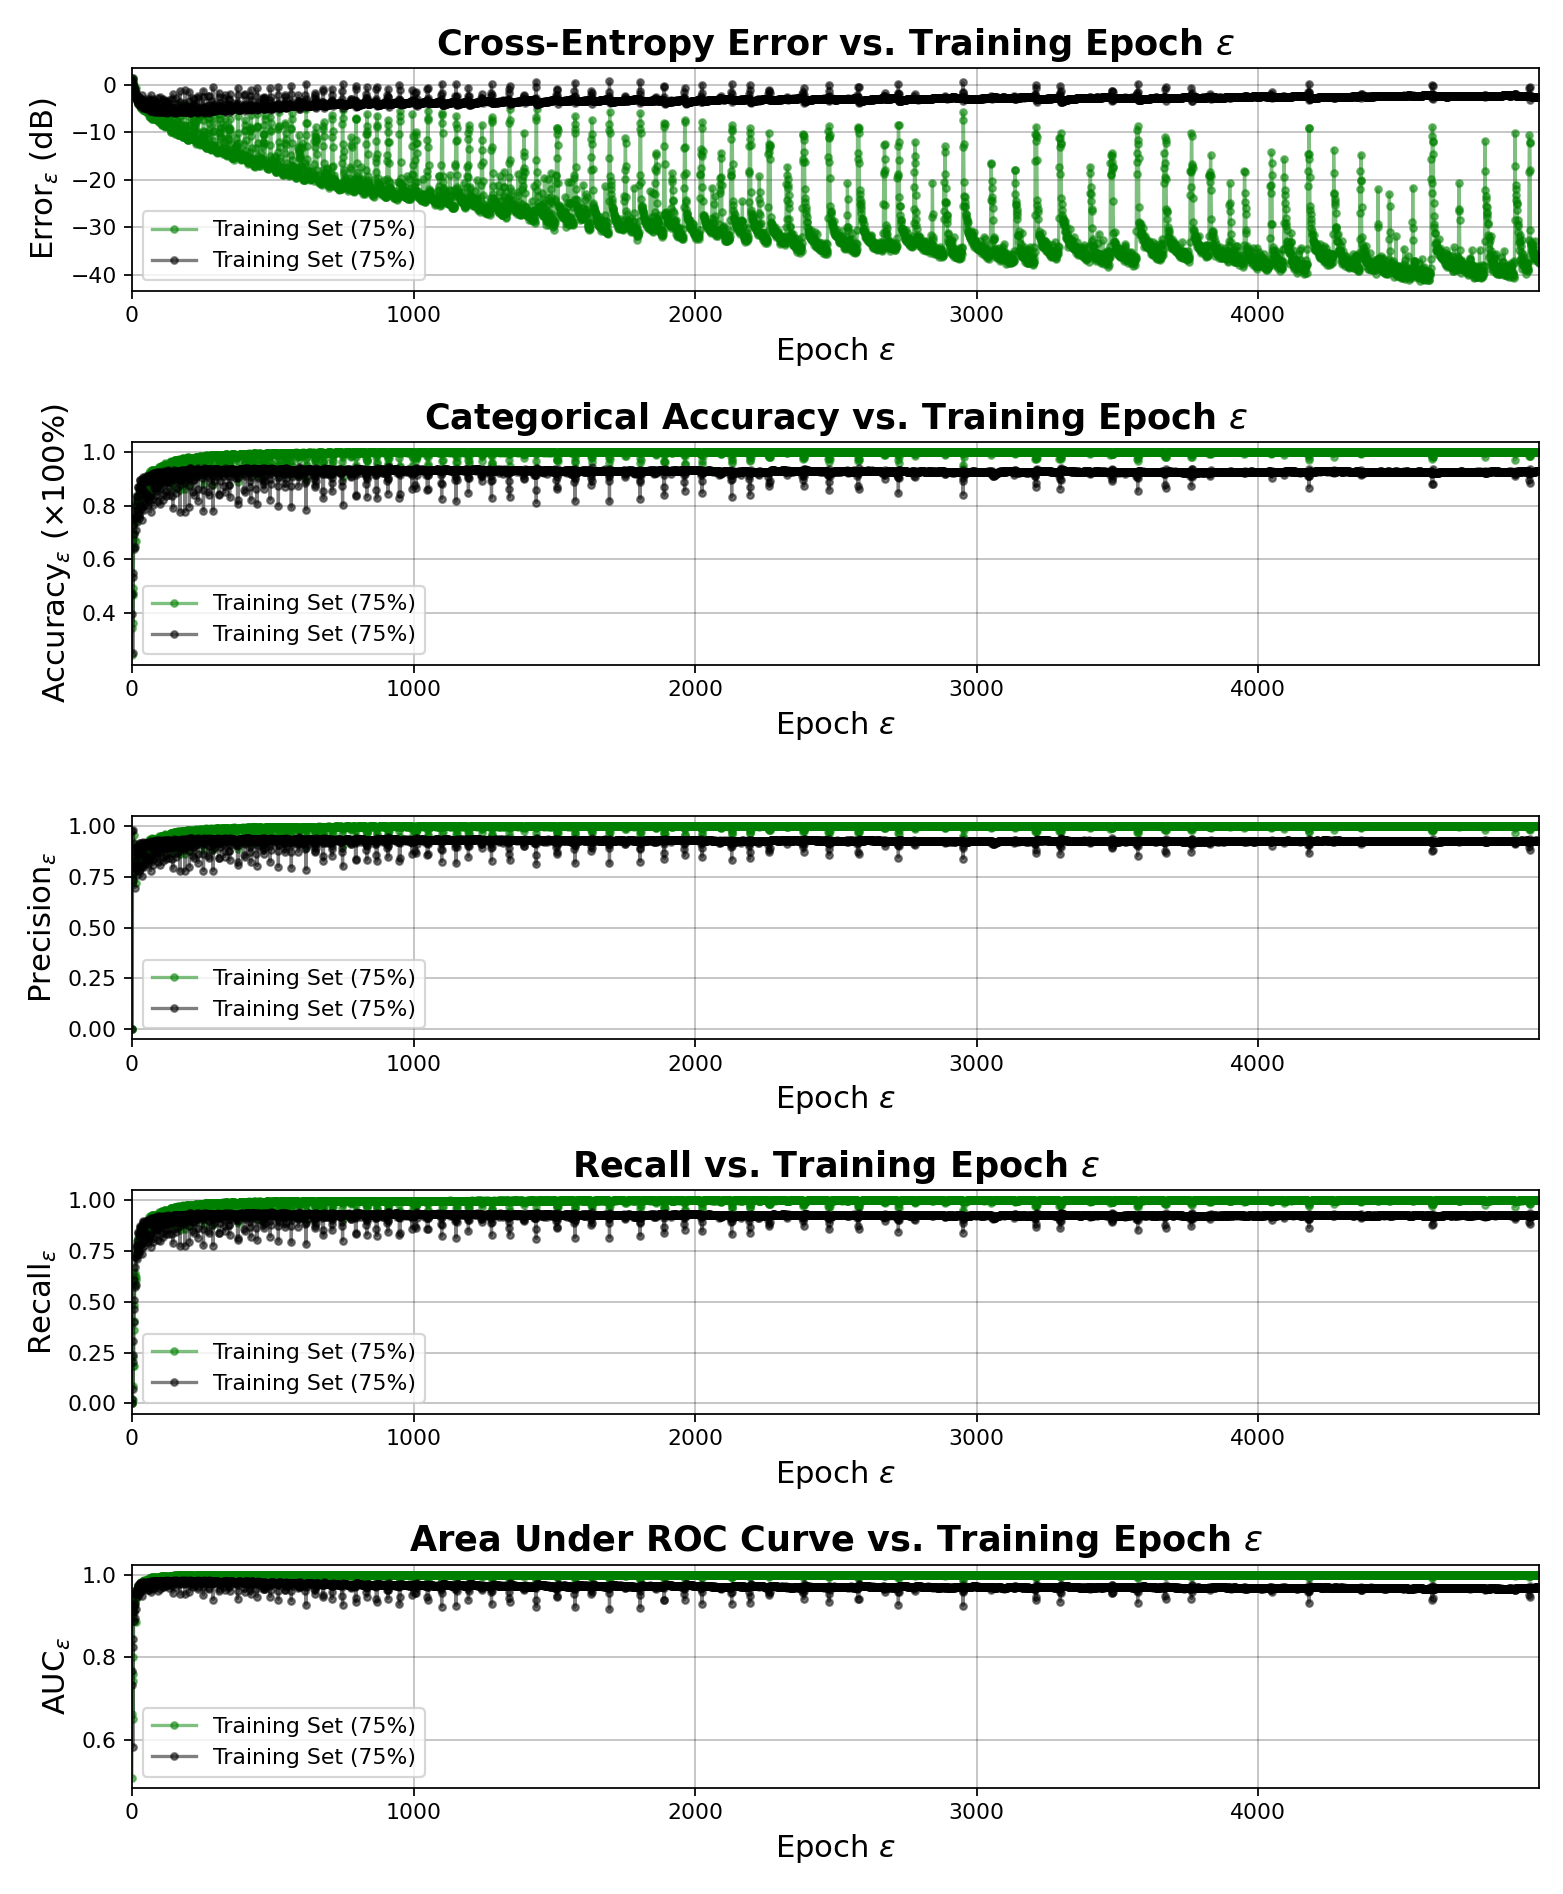

In [10]:
%matplotlib notebook

# Text legend labels for training set curves
train_set_lbl = ('Training Set (' + 
    str(int(100 * (1 - pct_validation))) + '%)');
    
# Text legend labels for validation set curves
val_set_lbl = ('Training Set (' + 
    str(int(100 * (1 - pct_validation))) + '%)');

# New figure
loss_fig = plt.figure(figsize=(9.9,12));

#############
# Loss plot #
#############
ax1 = plt.subplot(5,1,1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Linear grid of training epochs
epochs = arange(0,N_epoch);

# Cross-entropy error (dB) - training set
plt.plot(epochs,10 * log10(
    model.history.history['loss']),
    '.-',c='g',alpha=0.5,
    label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,10 * log10(
    model.history.history['val_loss']),
    '.-',c='k',alpha=0.5,
    label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Cross-Entropy Error vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Error${}_{\varepsilon}$ (dB)',fontsize=14);

# Legend
plt.legend();

#################
# Accuracy plot #
#################
plt.subplot(5,1,2,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['categorical_accuracy'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_categorical_accuracy'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Categorical Accuracy vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Accuracy${}_{\varepsilon}$ ($\times100\%$)',fontsize=14);

# Legend
plt.legend();

##################
# Precision plot #
##################
plt.subplot(5,1,3,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['precision'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_precision'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]); 

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Precision${}_{\varepsilon}$',fontsize=14);

# Legend
plt.legend();

###############
# Recall plot #
###############
plt.subplot(5,1,4,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['recall'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_recall'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Recall vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'Recall${}_{\varepsilon}$',fontsize=14);

# Legend
plt.legend();

############
# AUC plot #
############
plt.subplot(5,1,5,sharex=ax1);

# Add grid to axes
plt.grid(color='k',alpha=0.25);

# Cross-entropy error (dB) - training set
plt.plot(epochs,model.history.history['auc'],
    '.-',c='g',alpha=0.5,label=train_set_lbl);

# Cross-entropy error (dB) - validation set
plt.plot(epochs,model.history.history['val_auc'],
    '.-',c='k',alpha=0.5,label=val_set_lbl);

# Set x-axis limits
plt.xlim([epochs[0],epochs[-1]]);

# Title
plt.title(r'Area Under ROC Curve vs. Training Epoch $\varepsilon$',
          fontsize=16,weight='bold');

# x-axis label
plt.xlabel(r'Epoch $\varepsilon$',fontsize=14);

# y-axis label
plt.ylabel(r'AUC${}_{\varepsilon}$',fontsize=14);

# Legend
plt.legend();

# Optimize layout
plt.tight_layout();

### $\textbf{Pass Entire Dataset (i.e., Train }\cup\textbf{ Validation) to Model}$

In [11]:
# C x 1 class prediction for entire dataset
Y_hat = model.predict(
    X,                        # Input data
    batch_size=N_batch,       # Batch size
);

# Cast 1-hot class labels as ordinal labels
y_hat = argmax(Y_hat,axis=1); # Predictions
y_true = argmax(Y,axis=1);    # Ground truth

### $\textbf{Confusion Matrix Using Predictions Output Above}$

<IPython.core.display.Javascript object>


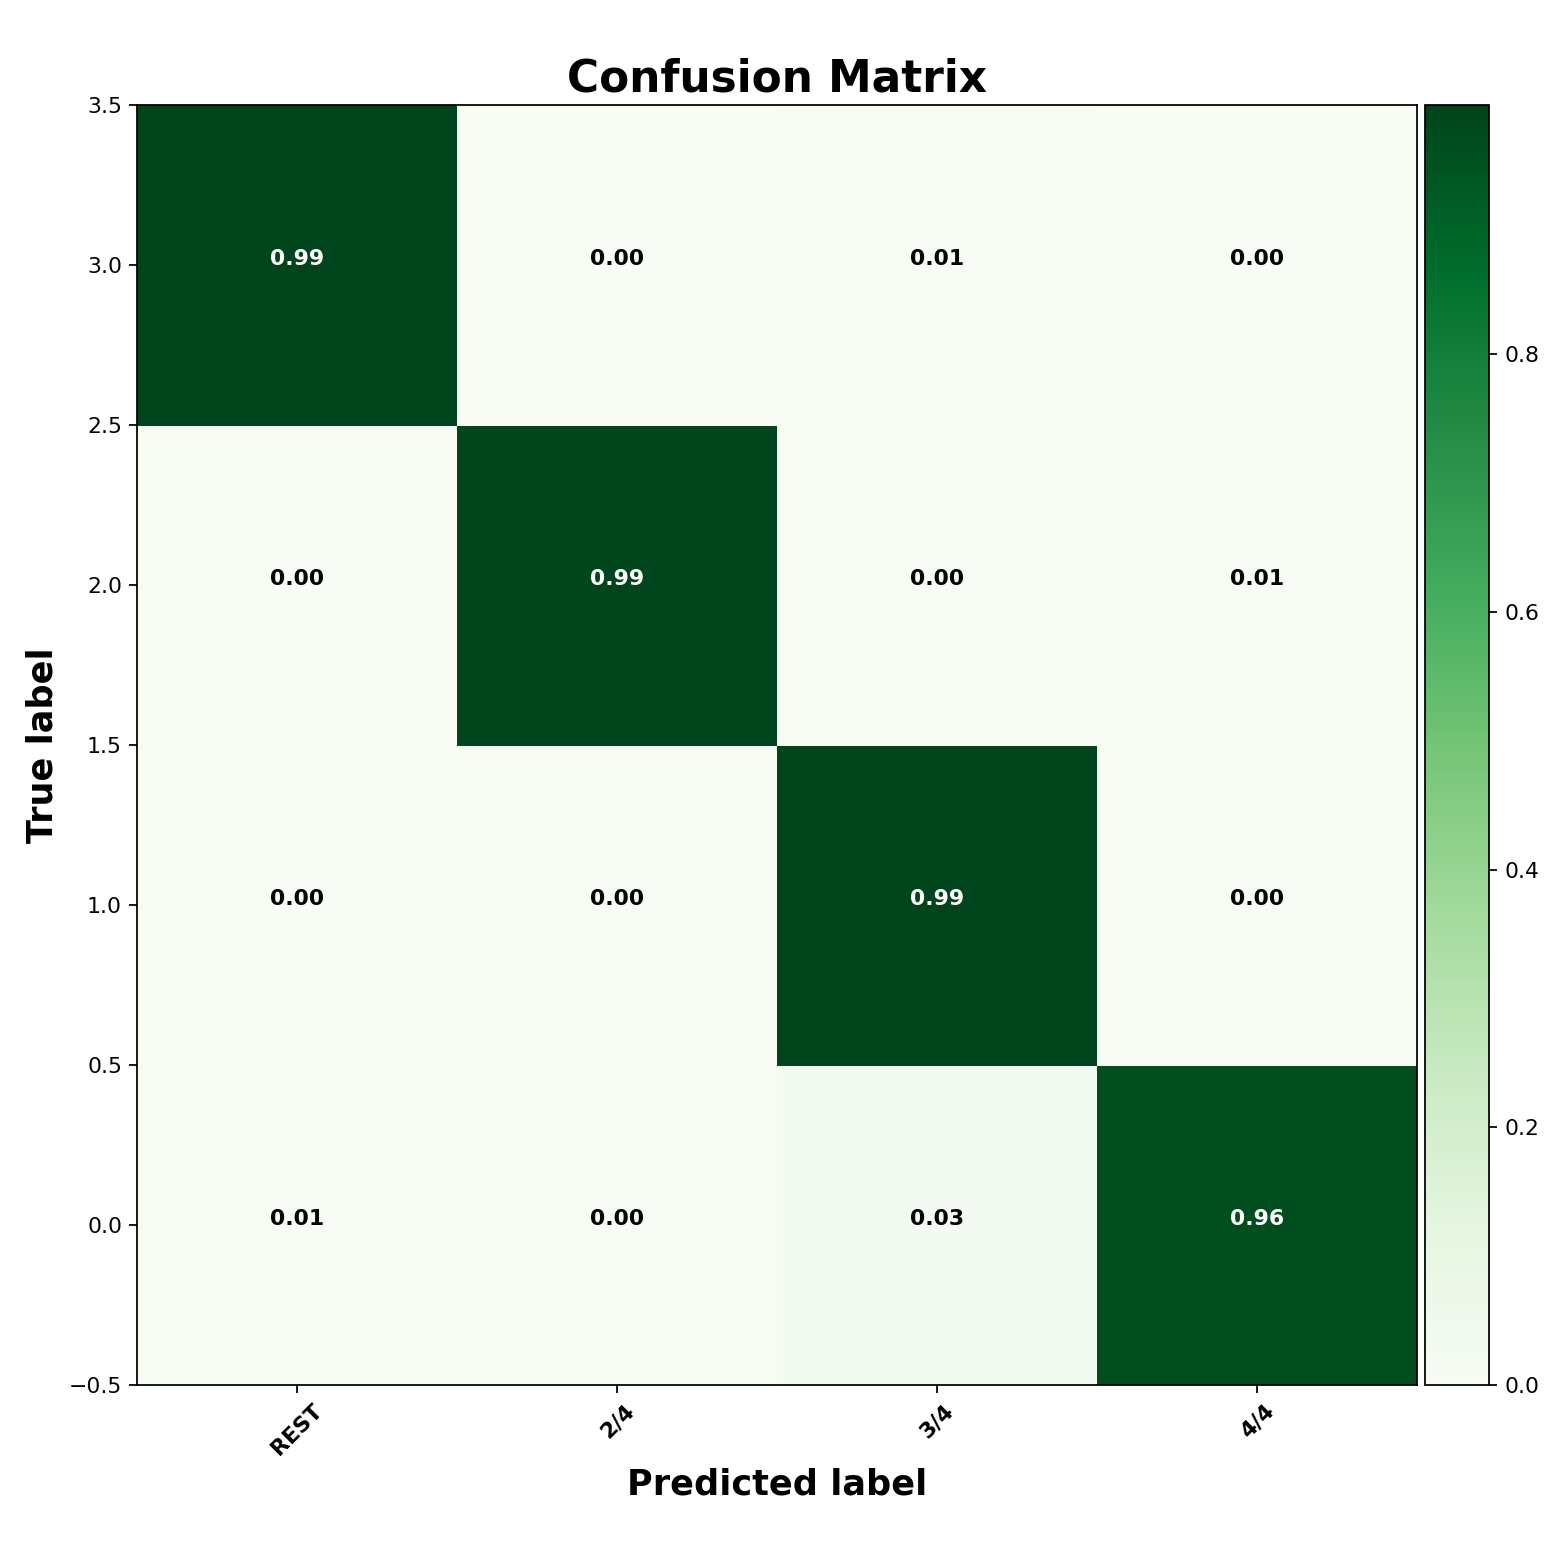

[[9.93570722e-01 9.89119683e-04 5.44015826e-03 0.00000000e+00]
 [1.80505415e-03 9.86762936e-01 4.21179302e-03 7.22021661e-03]
 [4.92853622e-04 3.94282898e-03 9.91128635e-01 4.43568260e-03]
 [7.21442886e-03 4.00801603e-03 2.56513026e-02 9.63126252e-01]]


In [12]:
#########################
#    Compute Matrix:    #
#########################

# Use the sklearn confusion matrix function
confusion_mat = confusion_matrix(y_true,y_hat,
    labels=[c for c in range(C)],sample_weight=None);

#########################
#   Confusion Plotter:  # - adapated from online example
#########################

def plot_confusion_matrix(C,classes,normalize=False,
            title='Confusion matrix',cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Let epsilon > 0 be small...
    epsilon = 1e-7;
    
    # Normalization of confusion matrix C
    if normalize:
        C = C.astype('float') / (epsilon + C.sum(axis=1)[:, newaxis]);

    # Print the matrix C
    print(C);
    
    # Image representation
    ax = plt.gca();   # <-- grab current axes
    C = flipud(C);    # <-- flip horizontally for visualization
    im = ax.imshow(C,cmap=cmap);
    
    # Colorbar
    colorbar(im);
    
    # Title
    plt.title(title,fontsize=20,weight="bold");
    
    # Tick labels
    tick_marks = arange(len(classes));
    plt.xticks(tick_marks, classes, rotation=45,fontweight="bold");
    
    # Overwrite default y-axis limits
    plt.ylim([-0.5,len(classes)-0.5]);

    # Text labels in tiles (i.e., elements)
    fmt = '.2f' if normalize else 'd'
    thresh = C.max() / 2.
    for i, j in iter_prod(range(C.shape[0]), range(C.shape[1])):
        plt.text(j, i, format(C[i, j], fmt),
                 horizontalalignment="center",weight="bold",
                 color="white" if C[i, j] > thresh else "black")

    # x-axis labels
    plt.ylabel('True label',fontsize=16,weight="bold");
    
    # y-axis labels
    plt.xlabel('Predicted label',fontsize=16,weight="bold");
    
    # Set axis layout
    plt.tight_layout();
    
#########################
#    Scale Colorbar:    # - found this online
#########################

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


#########################
#    Visualization:     #
#########################

conf_fig = plt.figure(figsize=(9.9,9.9));
plot_confusion_matrix(
    confusion_mat, 
    classes=[clss for clss in class_table],
    normalize=True,
    title='Confusion Matrix',
    cmap=plt.cm.Greens);